In [85]:
"""
Web scraping price information from www.mediamarkt.es
Based on:
https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py
"""

import ast
import requests
import urllib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

from bs4 import BeautifulSoup
from tqdm import tqdm

%matplotlib inline

In [2]:
# URL dónde está la lista de productos
URL = "https://www.mediamarkt.es/sitemap/sitemap-productlist.xml"

In [3]:
# Definimoos la función para leer el xml y extraer los links que pasaremos
# Referencia:
# https://stackoverflow.com/questions/18966368/python-beautifulsoup-scrape-tables
# Le paso la URL como parámetro, así podrá valer para los diferentes sitios.
def get_products (URL):
    soup = BeautifulSoup(requests.get(URL).text, 'lxml')
    #links = soup.find_all('loc')
    links = []
    #links = soup.find_all("loc")
    for link in soup.find_all("loc"):
        links.append(str(link).replace("<loc>","").replace("</loc>",""))
    return links

In [4]:
# Cargamos los links a partir del sitemap
pagelinks = get_products(URL)

In [5]:
# Mostramos los primeros 10
pagelinks[1:10]

['https://www.mediamarkt.es/es/category/_afeitado-y-depilaci%C3%B3n-701138.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-faciales-701281.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-corporales-701282.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-multifunci%C3%B3n-701283.html',
 'https://www.mediamarkt.es/es/category/_cortapelos-701284.html',
 'https://www.mediamarkt.es/es/category/_barberos-701285.html',
 'https://www.mediamarkt.es/es/category/_depiladoras-ipl-701286.html',
 'https://www.mediamarkt.es/es/category/_rasuradoras-701287.html',
 'https://www.mediamarkt.es/es/category/_depiladoras-de-arranque-701288.html']

In [6]:
#Compruebo los pagelinks
len(pagelinks)

1012

In [66]:
# Referencia del código:
# https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py
def npages(mysoup):
    pagination = list()
    npages = 0
    for page_number in mysoup.find_all('div', {'class': 'pagination-wrapper cf'}):
        pagination.append(page_number.find_all('a'))
        npages = int(str(pagination[0]).split(', ')[-2].strip('</a>').split('>')[-1])
        # Para debug, se imprime el número de páginas.
        print ("Número de páginas: %d" % npages)
    return npages        


def get_data(URL, output_file = None):
    # Para debug, se imprime la URL que se está escaneando
    print("Scraping: %s" % URL)
    item_list = list()    
    for page in tqdm(range(1, npages(BeautifulSoup(requests.get(URL).text, 'html.parser')) + 1)):
        soup = BeautifulSoup(requests.get(URL + '?page=' + str(page)).text, 'html.parser')
        all_scripts = soup.find_all('script')
        for script in all_scripts:
            if script.text.startswith('var product'):
                item_list.append(ast.literal_eval(script.text.split(' = ')[1].strip(';')))
    
    productinfo = pd.DataFrame() 
    if (len(item_list)>0):
        productinfo = pd.DataFrame(item_list)
        productinfo['price'] = pd.to_numeric(productinfo['price'], errors='coerce')
        
  
    #productinfo.to_csv(output_file, index=False)    
    #print(f'{productinfo.shape[0]} records saved to {output_file}')
    
    return productinfo

In [130]:
def viz_data(input_file, output_file, query = ':', x_px = 1500, y_px = 1000, d_pi = 150):
    productinfo = pd.read_csv(input_file)
    
    productinfo = productinfo[query]

    #x_pixels, y_pixels, dpi = 1500, 1000, 150
    x_pixels, y_pixels, dpi = x_px, y_px, d_pi
    x_inch, y_inch = x_pixels / dpi, y_pixels / dpi

    plt.figure(figsize=(x_inch, y_inch), dpi=dpi)
    sns.boxplot(x='price',
                y='brand',
                data=productinfo.groupby('brand').filter(lambda x: len(x) > 3),
                order=list(productinfo.groupby('brand').filter(lambda x: len(x) > 3)
                           .groupby('brand').price.median().sort_values(ascending=False).index),
                palette='PRGn',
                width=0.75).set_title('Price Distribution per Brand')
    sns.despine(offset=10, trim=True)
    plt.savefig(output_file)
    plt.show()
    plt.close()
    
    print(f'Visualization saved to {output_file}')


In [67]:
#def main():
dat = './data/productinfo.csv'
viz = './plots/price_distribution_brand.png'

# Limito a los 10 primeras líneas
products = pd.DataFrame()
total_products = pd.DataFrame()
k=0
#for link in pagelinks[1:10]:
for link in pagelinks:
    k += 1
    #print("Escaneando pagina %d de %d" % (k, len(pagelinks[1:10])))
    print("Escaneando pagina %d de %d" % (k, len(pagelinks)))
    products = get_data(link, dat)
    time.sleep(2)
    total_products = total_products.append(products)
        
print("Done. The prices have been scrapped.")


Escaneando pagina 1 de 1012
Scraping: https://www.mediamarkt.es/es/category/_belleza-y-salud-701113.html


0it [00:00, ?it/s]


Escaneando pagina 2 de 1012
Scraping: https://www.mediamarkt.es/es/category/_afeitado-y-depilaci%C3%B3n-701138.html


0it [00:00, ?it/s]


Escaneando pagina 3 de 1012
Scraping: https://www.mediamarkt.es/es/category/_afeitadoras-faciales-701281.html
Número de páginas: 3


100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Escaneando pagina 4 de 1012
Scraping: https://www.mediamarkt.es/es/category/_afeitadoras-corporales-701282.html


0it [00:00, ?it/s]


Escaneando pagina 5 de 1012
Scraping: https://www.mediamarkt.es/es/category/_afeitadoras-multifunci%C3%B3n-701283.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Escaneando pagina 6 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cortapelos-701284.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Escaneando pagina 7 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barberos-701285.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Escaneando pagina 8 de 1012
Scraping: https://www.mediamarkt.es/es/category/_depiladoras-ipl-701286.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Escaneando pagina 9 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rasuradoras-701287.html


0it [00:00, ?it/s]


Escaneando pagina 10 de 1012
Scraping: https://www.mediamarkt.es/es/category/_depiladoras-de-arranque-701288.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.57s/it]


Escaneando pagina 11 de 1012
Scraping: https://www.mediamarkt.es/es/category/_recambios-y-accesorios-701289.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Escaneando pagina 12 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-del-cabello-701139.html


0it [00:00, ?it/s]


Escaneando pagina 13 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secadores-de-pelo-701290.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Escaneando pagina 14 de 1012
Scraping: https://www.mediamarkt.es/es/category/_planchas-de-pelo-701291.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Escaneando pagina 15 de 1012
Scraping: https://www.mediamarkt.es/es/category/_moldeadores-de-pelo-701292.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Escaneando pagina 16 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cepillos-de-calor-701293.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Escaneando pagina 17 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rizadores-701294.html


0it [00:00, ?it/s]


Escaneando pagina 18 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-dental-701140.html


0it [00:00, ?it/s]


Escaneando pagina 19 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cepillos-de-dientes-701295.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Escaneando pagina 20 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cepillos-infantiles-701296.html


0it [00:00, ?it/s]


Escaneando pagina 21 de 1012
Scraping: https://www.mediamarkt.es/es/category/_irrigadores-701297.html


0it [00:00, ?it/s]


Escaneando pagina 22 de 1012
Scraping: https://www.mediamarkt.es/es/category/_recambios-cuidado-dental-701298.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Escaneando pagina 23 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-facial-701141.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Escaneando pagina 24 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%A1quinas-de-sauna-facial-701299.html


0it [00:00, ?it/s]


Escaneando pagina 25 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cepillos-y-limpiadores-faciales-701300.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Escaneando pagina 26 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rejuvenecedores-tonificadores-701301.html


0it [00:00, ?it/s]


Escaneando pagina 27 de 1012
Scraping: https://www.mediamarkt.es/es/category/_espejos-701302.html


0it [00:00, ?it/s]


Escaneando pagina 28 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-corporal-701142.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Escaneando pagina 29 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cavitaci%C3%B3n-y-radiofrecuencia-701303.html


0it [00:00, ?it/s]


Escaneando pagina 30 de 1012
Scraping: https://www.mediamarkt.es/es/category/_masajeadores-y-anticelul%C3%ADticos-701304.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Escaneando pagina 31 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cremas-y-tratamientos-corporales-701305.html


0it [00:00, ?it/s]


Escaneando pagina 32 de 1012
Scraping: https://www.mediamarkt.es/es/category/_packs-de-cuidado-corporal-701306.html


0it [00:00, ?it/s]


Escaneando pagina 33 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juguetes-sexuales-701307.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Escaneando pagina 34 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-de-pies-y-manos-701143.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.02it/s]


Escaneando pagina 35 de 1012
Scraping: https://www.mediamarkt.es/es/category/_manicura-y-pedicura-701308.html


0it [00:00, ?it/s]


Escaneando pagina 36 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secadores-y-l%C3%A1mparas-uv-led-701309.html


0it [00:00, ?it/s]


Escaneando pagina 37 de 1012
Scraping: https://www.mediamarkt.es/es/category/_kit-de-manicura-701310.html


0it [00:00, ?it/s]


Escaneando pagina 38 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sets-y-accesorios-701311.html


0it [00:00, ?it/s]


Escaneando pagina 39 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hidromasaje-y-parafina-701312.html


0it [00:00, ?it/s]


Escaneando pagina 40 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limadores-de-durezas-701313.html


0it [00:00, ?it/s]


Escaneando pagina 41 de 1012
Scraping: https://www.mediamarkt.es/es/category/_salud-y-bienestar-701144.html


0it [00:00, ?it/s]


Escaneando pagina 42 de 1012
Scraping: https://www.mediamarkt.es/es/category/_b%C3%A1sculas-de-ba%C3%B1o-701314.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.05it/s]


Escaneando pagina 43 de 1012
Scraping: https://www.mediamarkt.es/es/category/_almohadillas-el%C3%A9ctricas-701315.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Escaneando pagina 44 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%A1quinas-fitness-701316.html


0it [00:00, ?it/s]


Escaneando pagina 45 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mantas-el%C3%A9ctricas-701317.html


0it [00:00, ?it/s]


Escaneando pagina 46 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aparatos-m%C3%A9dicos-701318.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Escaneando pagina 47 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tensi%C3%B3metros-702262.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Escaneando pagina 48 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cardi%C3%B3metros-702263.html


0it [00:00, ?it/s]


Escaneando pagina 49 de 1012
Scraping: https://www.mediamarkt.es/es/category/_term%C3%B3metros-702264.html


0it [00:00, ?it/s]


Escaneando pagina 50 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pulsiox%C3%ADmetros-702265.html


0it [00:00, ?it/s]


Escaneando pagina 51 de 1012
Scraping: https://www.mediamarkt.es/es/category/_masaje-701319.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.01s/it]


Escaneando pagina 52 de 1012
Scraping: https://www.mediamarkt.es/es/category/_l%C3%A1mparas-de-infrarrojos-701320.html


0it [00:00, ?it/s]


Escaneando pagina 53 de 1012
Scraping: https://www.mediamarkt.es/es/category/_humidificadores-701321.html


0it [00:00, ?it/s]


Escaneando pagina 54 de 1012
Scraping: https://www.mediamarkt.es/es/category/_deshumificadores-701322.html


0it [00:00, ?it/s]


Escaneando pagina 55 de 1012
Scraping: https://www.mediamarkt.es/es/category/_purificadores-de-aire-701323.html


0it [00:00, ?it/s]


Escaneando pagina 56 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cuidado-del-beb%C3%A9-701145.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Escaneando pagina 57 de 1012
Scraping: https://www.mediamarkt.es/es/category/_vigilabeb%C3%A9s-701325.html


0it [00:00, ?it/s]


Escaneando pagina 58 de 1012
Scraping: https://www.mediamarkt.es/es/category/_b%C3%A1sculas-701326.html


0it [00:00, ?it/s]


Escaneando pagina 59 de 1012
Scraping: https://www.mediamarkt.es/es/category/_term%C3%B3metros-para-beb%C3%A9-701328.html


0it [00:00, ?it/s]


Escaneando pagina 60 de 1012
Scraping: https://www.mediamarkt.es/es/category/_humidificadores-701329.html


0it [00:00, ?it/s]


Escaneando pagina 61 de 1012
Scraping: https://www.mediamarkt.es/es/category/_preparaci%C3%B3n-alimentos-para-beb%C3%A9-701330.html


0it [00:00, ?it/s]


Escaneando pagina 62 de 1012
Scraping: https://www.mediamarkt.es/es/category/_campa%C3%B1as-y-ofertas-701114.html


0it [00:00, ?it/s]


Escaneando pagina 63 de 1012
Scraping: https://www.mediamarkt.es/es/category/_oportunidades-701125.html
Número de páginas: 30


100%|██████████| 30/30 [00:32<00:00,  1.07it/s]


Escaneando pagina 64 de 1012
Scraping: https://www.mediamarkt.es/es/category/_deporte-y-foto-712514.html


0it [00:00, ?it/s]


Escaneando pagina 65 de 1012
Scraping: https://www.mediamarkt.es/es/category/_electrodom%C3%A9sticos-712515.html
Número de páginas: 12


100%|██████████| 12/12 [00:10<00:00,  1.35it/s]


Escaneando pagina 66 de 1012
Scraping: https://www.mediamarkt.es/es/category/_entretenimiento-712516.html
Número de páginas: 10


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Escaneando pagina 67 de 1012
Scraping: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-712517.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Escaneando pagina 68 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-712518.html
Número de páginas: 4


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Escaneando pagina 69 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-y-audio-712519.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.01s/it]


Escaneando pagina 70 de 1012
Scraping: https://www.mediamarkt.es/es/category/_plan-renove-721079.html
Número de páginas: 61


100%|██████████| 61/61 [00:59<00:00,  1.07it/s]


Escaneando pagina 71 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-y-audio-721097.html
Número de páginas: 20


100%|██████████| 20/20 [00:20<00:00,  1.02it/s]


Escaneando pagina 72 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-4k-hasta-43-721105.html


0it [00:00, ?it/s]


Escaneando pagina 73 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-4k-de-44-a-55-721101.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Escaneando pagina 74 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-4k-de-56-a-65-721104.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Escaneando pagina 75 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-4k-a-partir-de-66-721100.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Escaneando pagina 76 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barras-de-sonido-721103.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Escaneando pagina 77 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-721102.html
Número de páginas: 9


100%|██████████| 9/9 [00:10<00:00,  1.24s/it]


Escaneando pagina 78 de 1012
Scraping: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-721095.html
Número de páginas: 21


100%|██████████| 21/21 [00:24<00:00,  1.20s/it]


Escaneando pagina 79 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-721108.html
Número de páginas: 8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Escaneando pagina 80 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pcs-721109.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Escaneando pagina 81 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-721110.html
Número de páginas: 11


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Escaneando pagina 82 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tablets-721111.html


0it [00:00, ?it/s]


Escaneando pagina 83 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-721096.html
Número de páginas: 9


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Escaneando pagina 84 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smartphones-721106.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Escaneando pagina 85 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smartwatches-721107.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Escaneando pagina 86 de 1012
Scraping: https://www.mediamarkt.es/es/category/_deporte-y-foto-721092.html
Número de páginas: 12


100%|██████████| 12/12 [00:17<00:00,  1.53s/it]


Escaneando pagina 87 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fotograf%C3%ADa-721112.html
Número de páginas: 10


100%|██████████| 10/10 [00:14<00:00,  1.38s/it]


Escaneando pagina 88 de 1012
Scraping: https://www.mediamarkt.es/es/category/_movilidad-721113.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Escaneando pagina 89 de 1012
Scraping: https://www.mediamarkt.es/es/category/_entretenimiento-721094.html


0it [00:00, ?it/s]


Escaneando pagina 90 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-audio-y-foto-701116.html


0it [00:00, ?it/s]


Escaneando pagina 91 de 1012
Scraping: https://www.mediamarkt.es/es/category/_televisi%C3%B3n-701130.html


0it [00:00, ?it/s]


Escaneando pagina 92 de 1012
Scraping: https://www.mediamarkt.es/es/category/_televisores-701210.html
Número de páginas: 11


100%|██████████| 11/11 [00:12<00:00,  1.05s/it]


Escaneando pagina 93 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-hasta-27-pulgadas-702040.html


0it [00:00, ?it/s]


Escaneando pagina 94 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-28-32-pulgadas-702041.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Escaneando pagina 95 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-40-43-pulgadas-702042.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Escaneando pagina 96 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-48-50-pulgadas-702043.html


0it [00:00, ?it/s]


Escaneando pagina 97 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-55-60-pulgadas-702044.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Escaneando pagina 98 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-desde-65-pulgadas-702045.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Escaneando pagina 99 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-tv-701211.html
Número de páginas: 9


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


Escaneando pagina 100 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-fijos-702046.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 101 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-inclinable-702047.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Escaneando pagina 102 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-con-brazo-702048.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Escaneando pagina 103 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tv-techo-702049.html


0it [00:00, ?it/s]


Escaneando pagina 104 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-proyector-702050.html


0it [00:00, ?it/s]


Escaneando pagina 105 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-altavoces-702051.html


0it [00:00, ?it/s]


Escaneando pagina 106 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-soportes-702052.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Escaneando pagina 107 de 1012
Scraping: https://www.mediamarkt.es/es/category/_internet-tv-tdt-sat%C3%A9lite-701212.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Escaneando pagina 108 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smart-tv-box-702053.html


0it [00:00, ?it/s]


Escaneando pagina 109 de 1012
Scraping: https://www.mediamarkt.es/es/category/_receptor-tdt-702054.html


0it [00:00, ?it/s]


Escaneando pagina 110 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sat%C3%A9lite-702055.html


0it [00:00, ?it/s]


Escaneando pagina 111 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-teclados-smart-tv-702057.html


0it [00:00, ?it/s]


Escaneando pagina 112 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-702058.html


0it [00:00, ?it/s]


Escaneando pagina 113 de 1012
Scraping: https://www.mediamarkt.es/es/category/_proyectores-701213.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Escaneando pagina 114 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cine-en-casa-3d-702059.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando pagina 115 de 1012
Scraping: https://www.mediamarkt.es/es/category/_profesional-702060.html


0it [00:00, ?it/s]


Escaneando pagina 116 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mini-proyectores-702061.html


0it [00:00, ?it/s]


Escaneando pagina 117 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pantallas-proyecci%C3%B3n-702062.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Escaneando pagina 118 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-702063.html


0it [00:00, ?it/s]


Escaneando pagina 119 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-proyectores-702064.html


0it [00:00, ?it/s]


Escaneando pagina 120 de 1012
Scraping: https://www.mediamarkt.es/es/category/_reproductores-dvd-blu-ray-701214.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Escaneando pagina 121 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bluray-smart-tv-702065.html


0it [00:00, ?it/s]


Escaneando pagina 122 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dvd-702066.html


0it [00:00, ?it/s]


Escaneando pagina 123 de 1012
Scraping: https://www.mediamarkt.es/es/category/_blu-ray-702067.html


0it [00:00, ?it/s]


Escaneando pagina 124 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dvd-port%C3%A1til-702068.html


0it [00:00, ?it/s]


Escaneando pagina 125 de 1012
Scraping: https://www.mediamarkt.es/es/category/_antenas-tv-701218.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Escaneando pagina 126 de 1012
Scraping: https://www.mediamarkt.es/es/category/_antenas-exteriores-702075.html


0it [00:00, ?it/s]


Escaneando pagina 127 de 1012
Scraping: https://www.mediamarkt.es/es/category/_antenas-interiores-702076.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando pagina 128 de 1012
Scraping: https://www.mediamarkt.es/es/category/_amplificadores-antena-702077.html


0it [00:00, ?it/s]


Escaneando pagina 129 de 1012
Scraping: https://www.mediamarkt.es/es/category/_transmisores-se%C3%B1al-702078.html


0it [00:00, ?it/s]


Escaneando pagina 130 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-y-accesorios-702079.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Escaneando pagina 131 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-a-distancia-701219.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Escaneando pagina 132 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-universales-702080.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Escaneando pagina 133 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-teclados-smart-tv-702081.html


0it [00:00, ?it/s]


Escaneando pagina 134 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pilas-702082.html


0it [00:00, ?it/s]


Escaneando pagina 135 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-tv-701220.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Escaneando pagina 136 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-hdmi-702083.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Escaneando pagina 137 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-euroconector-702084.html


0it [00:00, ?it/s]


Escaneando pagina 138 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-antena-702085.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Escaneando pagina 139 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-v%C3%ADdeo-702086.html


0it [00:00, ?it/s]


Escaneando pagina 140 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-audio-video-702087.html


0it [00:00, ?it/s]


Escaneando pagina 141 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-televisi%C3%B3n-701222.html


0it [00:00, ?it/s]


Escaneando pagina 142 de 1012
Scraping: https://www.mediamarkt.es/es/category/_audio-y-hifi-701131.html


0it [00:00, ?it/s]


Escaneando pagina 143 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-hifi-701223.html
Número de páginas: 37


100%|██████████| 37/37 [01:00<00:00,  1.42s/it]


Escaneando pagina 144 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-inal%C3%A1mbricos-702088.html
Número de páginas: 19


100%|██████████| 19/19 [00:29<00:00,  1.41s/it]


Escaneando pagina 145 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-inteligentes-716009.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Escaneando pagina 146 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-para-pc-702089.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Escaneando pagina 147 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-bluetooth-702579.html


0it [00:00, ?it/s]


Escaneando pagina 148 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-5-1-702580.html


0it [00:00, ?it/s]


Escaneando pagina 149 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-2-1-702581.html


0it [00:00, ?it/s]


Escaneando pagina 150 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-jack-3-5-702582.html


0it [00:00, ?it/s]


Escaneando pagina 151 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-usb-702583.html


0it [00:00, ?it/s]


Escaneando pagina 152 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sistema-multiroom-702090.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Escaneando pagina 153 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-multiroom-702584.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando pagina 154 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barras-de-sonido-multiroom-702585.html


0it [00:00, ?it/s]


Escaneando pagina 155 de 1012
Scraping: https://www.mediamarkt.es/es/category/_amplificadores-multiroom-702586.html


0it [00:00, ?it/s]


Escaneando pagina 156 de 1012
Scraping: https://www.mediamarkt.es/es/category/_torres-de-sonido-702091.html


0it [00:00, ?it/s]


Escaneando pagina 157 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-hifi-est%C3%A9reo-702092.html
Número de páginas: 6


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Escaneando pagina 158 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-exterior-702587.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01it/s]


Escaneando pagina 159 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-autoamplificados-702588.html


0it [00:00, ?it/s]


Escaneando pagina 160 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-de-suelo-702589.html


0it [00:00, ?it/s]


Escaneando pagina 161 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-de-estanter%C3%ADa-702590.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Escaneando pagina 162 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-gran-potencia-702093.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Escaneando pagina 163 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-altavoces-702095.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.25s/it]


Escaneando pagina 164 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-audio-702591.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Escaneando pagina 165 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-para-altavoces-702592.html


0it [00:00, ?it/s]


Escaneando pagina 166 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-multiroom-702593.html


0it [00:00, ?it/s]


Escaneando pagina 167 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-para-altavoces-702594.html


0it [00:00, ?it/s]


Escaneando pagina 168 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-resistentes-al-agua-711009.html


0it [00:00, ?it/s]


Escaneando pagina 169 de 1012
Scraping: https://www.mediamarkt.es/es/category/_home-cinema-701224.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Escaneando pagina 170 de 1012
Scraping: https://www.mediamarkt.es/es/category/_home-cinema-2-1-canales-702096.html


0it [00:00, ?it/s]


Escaneando pagina 171 de 1012
Scraping: https://www.mediamarkt.es/es/category/_home-cinema-5-1-canales-702097.html


0it [00:00, ?it/s]


Escaneando pagina 172 de 1012
Scraping: https://www.mediamarkt.es/es/category/_subwoofer-702099.html


0it [00:00, ?it/s]


Escaneando pagina 173 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barras-de-sonido-701225.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


Escaneando pagina 174 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barras-sonido-con-subwoofer-702100.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Escaneando pagina 175 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sin-subwoofer-702101.html


0it [00:00, ?it/s]


Escaneando pagina 176 de 1012
Scraping: https://www.mediamarkt.es/es/category/_reproductores-de-m%C3%BAsica-701226.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Escaneando pagina 177 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ipods-702102.html


0it [00:00, ?it/s]


Escaneando pagina 178 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mp3-702103.html


0it [00:00, ?it/s]


Escaneando pagina 179 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mp4-mp5-702104.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Escaneando pagina 180 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mp3-mp4-deportivos-702105.html


0it [00:00, ?it/s]


Escaneando pagina 181 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-701227.html


0it [00:00, ?it/s]


Escaneando pagina 182 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-inal%C3%A1mbricos-702109.html
Número de páginas: 15


100%|██████████| 15/15 [00:16<00:00,  1.02s/it]


Escaneando pagina 183 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-true-wireless-715087.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Escaneando pagina 184 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-de-bot%C3%B3n-702108.html
Número de páginas: 16


100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Escaneando pagina 185 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-con-cable-702107.html
Número de páginas: 10


100%|██████████| 10/10 [00:13<00:00,  1.47s/it]


Escaneando pagina 186 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auric-cancelaci%C3%B3n-ruido-702110.html


0it [00:00, ?it/s]


Escaneando pagina 187 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-gaming-702106.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Escaneando pagina 188 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-deportivos-702112.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Escaneando pagina 189 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-auriculares-702113.html


0it [00:00, ?it/s]


Escaneando pagina 190 de 1012
Scraping: https://www.mediamarkt.es/es/category/_minicadenas-microcadenas-701228.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Escaneando pagina 191 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hifi-701229.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.48s/it]


Escaneando pagina 192 de 1012
Scraping: https://www.mediamarkt.es/es/category/_receptores-av-702114.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Escaneando pagina 193 de 1012
Scraping: https://www.mediamarkt.es/es/category/_amplificador-est%C3%A9reo-702115.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.34s/it]


Escaneando pagina 194 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tocadiscos-702116.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Escaneando pagina 195 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lector-cd-702117.html


0it [00:00, ?it/s]


Escaneando pagina 196 de 1012
Scraping: https://www.mediamarkt.es/es/category/_micr%C3%B3fonos-702118.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando pagina 197 de 1012
Scraping: https://www.mediamarkt.es/es/category/_packs-hifi-702119.html


0it [00:00, ?it/s]


Escaneando pagina 198 de 1012
Scraping: https://www.mediamarkt.es/es/category/_zona-dj-701230.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Escaneando pagina 199 de 1012
Scraping: https://www.mediamarkt.es/es/category/_controladores-dj-702120.html


0it [00:00, ?it/s]


Escaneando pagina 200 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mezcladoras-dj-702121.html


0it [00:00, ?it/s]


Escaneando pagina 201 de 1012
Scraping: https://www.mediamarkt.es/es/category/_plato-dj-702122.html


0it [00:00, ?it/s]


Escaneando pagina 202 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-dj-702123.html


0it [00:00, ?it/s]


Escaneando pagina 203 de 1012
Scraping: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-y-efectos-702125.html


0it [00:00, ?it/s]


Escaneando pagina 204 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-zona-dj-702126.html


0it [00:00, ?it/s]


Escaneando pagina 205 de 1012
Scraping: https://www.mediamarkt.es/es/category/_radio-y-cd-port%C3%A1til-701231.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


Escaneando pagina 206 de 1012
Scraping: https://www.mediamarkt.es/es/category/_radio-port%C3%A1til-702127.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Escaneando pagina 207 de 1012
Scraping: https://www.mediamarkt.es/es/category/_radio-cd-702128.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 208 de 1012
Scraping: https://www.mediamarkt.es/es/category/_despertadores-702130.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.34s/it]


Escaneando pagina 209 de 1012
Scraping: https://www.mediamarkt.es/es/category/_grabadoras-de-voz-701232.html


0it [00:00, ?it/s]


Escaneando pagina 210 de 1012
Scraping: https://www.mediamarkt.es/es/category/_car-audio-y-gps-701233.html


0it [00:00, ?it/s]


Escaneando pagina 211 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gps-702131.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Escaneando pagina 212 de 1012
Scraping: https://www.mediamarkt.es/es/category/_coche-702595.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Escaneando pagina 213 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cami%C3%B3n-y-caravana-702596.html


0it [00:00, ?it/s]


Escaneando pagina 214 de 1012
Scraping: https://www.mediamarkt.es/es/category/_autorradios-702132.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Escaneando pagina 215 de 1012
Scraping: https://www.mediamarkt.es/es/category/_1-din-702599.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Escaneando pagina 216 de 1012
Scraping: https://www.mediamarkt.es/es/category/_2-din-702600.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Escaneando pagina 217 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-y-subwoofers-702133.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Escaneando pagina 218 de 1012
Scraping: https://www.mediamarkt.es/es/category/_etapa-de-potencia-702134.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Escaneando pagina 219 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dvd-coche-702135.html


0it [00:00, ?it/s]


Escaneando pagina 220 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-para-coches-702136.html


0it [00:00, ?it/s]


Escaneando pagina 221 de 1012
Scraping: https://www.mediamarkt.es/es/category/_avisadores-702137.html


0it [00:00, ?it/s]


Escaneando pagina 222 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-coche-702138.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.02s/it]


Escaneando pagina 223 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-gps-702601.html


0it [00:00, ?it/s]


Escaneando pagina 224 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smartphone-702602.html


0it [00:00, ?it/s]


Escaneando pagina 225 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tablet-y-dvd-702603.html


0it [00:00, ?it/s]


Escaneando pagina 226 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-car-audio-y-gps-702139.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Escaneando pagina 227 de 1012
Scraping: https://www.mediamarkt.es/es/category/_transmisores-fm-702604.html


0it [00:00, ?it/s]


Escaneando pagina 228 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-coche-702605.html


0it [00:00, ?it/s]


Escaneando pagina 229 de 1012
Scraping: https://www.mediamarkt.es/es/category/_funda-gps-702606.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Escaneando pagina 230 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cable-coche-702607.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando pagina 231 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702608.html


0it [00:00, ?it/s]


Escaneando pagina 232 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fotograf%C3%ADa-701129.html


0it [00:00, ?it/s]


Escaneando pagina 233 de 1012
Scraping: https://www.mediamarkt.es/es/category/_drones-701208.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 234 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-r%C3%A9flex-701197.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Escaneando pagina 235 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-evil-701199.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Escaneando pagina 236 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-bridge-701200.html


0it [00:00, ?it/s]


Escaneando pagina 237 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-compactas-701198.html
Número de páginas: 7


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Escaneando pagina 238 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1mara-compacta-701504.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Escaneando pagina 239 de 1012
Scraping: https://www.mediamarkt.es/es/category/_acu%C3%A1ticas-701505.html


0it [00:00, ?it/s]


Escaneando pagina 240 de 1012
Scraping: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-y-retro-701506.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Escaneando pagina 241 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-deportivas-701201.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Escaneando pagina 242 de 1012
Scraping: https://www.mediamarkt.es/es/category/_videoc%C3%A1maras-701507.html


0it [00:00, ?it/s]


Escaneando pagina 243 de 1012
Scraping: https://www.mediamarkt.es/es/category/_videoc%C3%A1maras-deportivas-702008.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Escaneando pagina 244 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-videoc%C3%A1mara-702009.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Escaneando pagina 245 de 1012
Scraping: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-y-retro-701202.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Escaneando pagina 246 de 1012
Scraping: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-702010.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Escaneando pagina 247 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papel-fotogr%C3%A1fico-702011.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Escaneando pagina 248 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-instant%C3%A1nea-702012.html


0it [00:00, ?it/s]


Escaneando pagina 249 de 1012
Scraping: https://www.mediamarkt.es/es/category/_objetivos-c%C3%A1mara-701203.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.34s/it]


Escaneando pagina 250 de 1012
Scraping: https://www.mediamarkt.es/es/category/_objetivos-reflex-702013.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Escaneando pagina 251 de 1012
Scraping: https://www.mediamarkt.es/es/category/_objetivos-evil-702014.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Escaneando pagina 252 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-objetivo-702015.html


0it [00:00, ?it/s]


Escaneando pagina 253 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tr%C3%ADpodes-c%C3%A1mara-701204.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Escaneando pagina 254 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tr%C3%ADpodes-702016.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Escaneando pagina 255 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monopies-702017.html


0it [00:00, ?it/s]


Escaneando pagina 256 de 1012
Scraping: https://www.mediamarkt.es/es/category/_minitr%C3%ADpodes-702018.html


0it [00:00, ?it/s]


Escaneando pagina 257 de 1012
Scraping: https://www.mediamarkt.es/es/category/_r%C3%B3tulas-702019.html


0it [00:00, ?it/s]


Escaneando pagina 258 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-702020.html


0it [00:00, ?it/s]


Escaneando pagina 259 de 1012
Scraping: https://www.mediamarkt.es/es/category/_empu%C3%B1aduras-702021.html


0it [00:00, ?it/s]


Escaneando pagina 260 de 1012
Scraping: https://www.mediamarkt.es/es/category/_flashes-701205.html


0it [00:00, ?it/s]


Escaneando pagina 261 de 1012
Scraping: https://www.mediamarkt.es/es/category/_flash-702022.html


0it [00:00, ?it/s]


Escaneando pagina 262 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-flash-702023.html


0it [00:00, ?it/s]


Escaneando pagina 263 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-foto-701206.html
Número de páginas: 27


100%|██████████| 27/27 [00:36<00:00,  1.08s/it]


Escaneando pagina 264 de 1012
Scraping: https://www.mediamarkt.es/es/category/_acc-c%C3%A1mara-deportiva-702024.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Escaneando pagina 265 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-c%C3%A1mara-702537.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando pagina 266 de 1012
Scraping: https://www.mediamarkt.es/es/category/_carcasas-702538.html


0it [00:00, ?it/s]


Escaneando pagina 267 de 1012
Scraping: https://www.mediamarkt.es/es/category/_palos-702539.html


0it [00:00, ?it/s]


Escaneando pagina 268 de 1012
Scraping: https://www.mediamarkt.es/es/category/_flotadores-702540.html


0it [00:00, ?it/s]


Escaneando pagina 269 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-deportiva-702541.html


0it [00:00, ?it/s]


Escaneando pagina 270 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtros-y-lentes-702542.html


0it [00:00, ?it/s]


Escaneando pagina 271 de 1012
Scraping: https://www.mediamarkt.es/es/category/_control-remoto-702543.html


0it [00:00, ?it/s]


Escaneando pagina 272 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADa-y-carga-702544.html


0it [00:00, ?it/s]


Escaneando pagina 273 de 1012
Scraping: https://www.mediamarkt.es/es/category/_flash-camara-deportiva-702546.html


0it [00:00, ?it/s]


Escaneando pagina 274 de 1012
Scraping: https://www.mediamarkt.es/es/category/_acc-foto-profesional-702025.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Escaneando pagina 275 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-flash-702547.html


0it [00:00, ?it/s]


Escaneando pagina 276 de 1012
Scraping: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-profesional-702548.html


0it [00:00, ?it/s]


Escaneando pagina 277 de 1012
Scraping: https://www.mediamarkt.es/es/category/_disparadores-y-transmisores-702550.html


0it [00:00, ?it/s]


Escaneando pagina 278 de 1012
Scraping: https://www.mediamarkt.es/es/category/_micr%C3%B3fonos-fotograf%C3%ADa-702551.html


0it [00:00, ?it/s]


Escaneando pagina 279 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-c%C3%A1mara-702552.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Escaneando pagina 280 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1maras-702026.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


Escaneando pagina 281 de 1012
Scraping: https://www.mediamarkt.es/es/category/_anal%C3%B3gicas-702553.html


0it [00:00, ?it/s]


Escaneando pagina 282 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-compacta-702554.html


0it [00:00, ?it/s]


Escaneando pagina 283 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bridge-y-evil-702555.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Escaneando pagina 284 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-y-correas-reflex-702556.html
Número de páginas: 8


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Escaneando pagina 285 de 1012
Scraping: https://www.mediamarkt.es/es/category/_correas-702557.html


0it [00:00, ?it/s]


Escaneando pagina 286 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-objetivos-702558.html


0it [00:00, ?it/s]


Escaneando pagina 287 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-videoc%C3%A1mara-702559.html


0it [00:00, ?it/s]


Escaneando pagina 288 de 1012
Scraping: https://www.mediamarkt.es/es/category/_protectores-pantalla-c%C3%A1mara-702560.html


0it [00:00, ?it/s]


Escaneando pagina 289 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papel-fotogr%C3%A1fico-702027.html


0it [00:00, ?it/s]


Escaneando pagina 290 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papel-para-impresora-702561.html


0it [00:00, ?it/s]


Escaneando pagina 291 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papel-instant%C3%A1neo-702562.html


0it [00:00, ?it/s]


Escaneando pagina 292 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-y-escanners-702028.html


0it [00:00, ?it/s]


Escaneando pagina 293 de 1012
Scraping: https://www.mediamarkt.es/es/category/_esc%C3%A1ner-fotogr%C3%A1fico-702563.html


0it [00:00, ?it/s]


Escaneando pagina 294 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-fotos-702564.html


0it [00:00, ?it/s]


Escaneando pagina 295 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtros-y-tapas-702029.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Escaneando pagina 296 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtros-uv-702565.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.65s/it]


Escaneando pagina 297 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtros-polarizados-702566.html


0it [00:00, ?it/s]


Escaneando pagina 298 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tapas-702567.html


0it [00:00, ?it/s]


Escaneando pagina 299 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-%C3%B3ptica-702568.html


0it [00:00, ?it/s]


Escaneando pagina 300 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADas-y-pilas-702030.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Escaneando pagina 301 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pilas-bot%C3%B3n-y-especiales-702573.html


0it [00:00, ?it/s]


Escaneando pagina 302 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADas-c%C3%A1maras-702569.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Escaneando pagina 303 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-pilas-bater%C3%ADas-702570.html


0it [00:00, ?it/s]


Escaneando pagina 304 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pilas-aa-702571.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Escaneando pagina 305 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pilas-aaa-702572.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Escaneando pagina 306 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjeta-de-memoria-foto-702031.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Escaneando pagina 307 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-sdhc-foto-702574.html


0it [00:00, ?it/s]


Escaneando pagina 308 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjeta-micro-sd-702575.html


0it [00:00, ?it/s]


Escaneando pagina 309 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-compact-flash-702576.html


0it [00:00, ?it/s]


Escaneando pagina 310 de 1012
Scraping: https://www.mediamarkt.es/es/category/_prism%C3%A1ticos-y-%C3%B3ptica-701207.html
Número de páginas: 6


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Escaneando pagina 311 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telescopios-702032.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando pagina 312 de 1012
Scraping: https://www.mediamarkt.es/es/category/_prism%C3%A1ticos-702033.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.01s/it]


Escaneando pagina 313 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microscopios-702034.html


0it [00:00, ?it/s]


Escaneando pagina 314 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monoculares-702035.html


0it [00:00, ?it/s]


Escaneando pagina 315 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-y-accesorios-702037.html


0it [00:00, ?it/s]


Escaneando pagina 316 de 1012
Scraping: https://www.mediamarkt.es/es/category/_marcos-digitales-y-%C3%A1lbumes-701209.html


0it [00:00, ?it/s]


Escaneando pagina 317 de 1012
Scraping: https://www.mediamarkt.es/es/category/_marcos-digitales-702038.html


0it [00:00, ?it/s]


Escaneando pagina 318 de 1012
Scraping: https://www.mediamarkt.es/es/category/_%C3%A1lbumes-702039.html


0it [00:00, ?it/s]


Escaneando pagina 319 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hogar-701117.html


0it [00:00, ?it/s]


Escaneando pagina 320 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocina-701132.html


0it [00:00, ?it/s]


Escaneando pagina 321 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-701234.html


0it [00:00, ?it/s]


Escaneando pagina 322 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-combinados-702140.html
Número de páginas: 11


100%|██████████| 11/11 [00:11<00:00,  1.05it/s]


Escaneando pagina 323 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-americanos-702141.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Escaneando pagina 324 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-dos-puertas-702142.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.46s/it]


Escaneando pagina 325 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-una-puerta-702143.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Escaneando pagina 326 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mini-frigor%C3%ADficos-702144.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 327 de 1012
Scraping: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-integrables-702145.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 328 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-frigor%C3%ADficos-702146.html


0it [00:00, ?it/s]


Escaneando pagina 329 de 1012
Scraping: https://www.mediamarkt.es/es/category/_congeladores-701235.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Escaneando pagina 330 de 1012
Scraping: https://www.mediamarkt.es/es/category/_congeladores-verticales-702147.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Escaneando pagina 331 de 1012
Scraping: https://www.mediamarkt.es/es/category/_congeladores-bajo-encimera-702148.html


0it [00:00, ?it/s]


Escaneando pagina 332 de 1012
Scraping: https://www.mediamarkt.es/es/category/_congeladores-horizontales-702149.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Escaneando pagina 333 de 1012
Scraping: https://www.mediamarkt.es/es/category/_congeladores-integrables-702150.html


0it [00:00, ?it/s]


Escaneando pagina 334 de 1012
Scraping: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-t%C3%A9-701236.html


0it [00:00, ?it/s]


Escaneando pagina 335 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-monodosis-702151.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Escaneando pagina 336 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-nespresso-702609.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Escaneando pagina 337 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-dolce-gusto-702610.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Escaneando pagina 338 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-tassimo-702611.html


0it [00:00, ?it/s]


Escaneando pagina 339 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-senseo-702612.html


0it [00:00, ?it/s]


Escaneando pagina 340 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-superautom%C3%A1ticas-702152.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Escaneando pagina 341 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-express-702153.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Escaneando pagina 342 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-de-goteo-702154.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


Escaneando pagina 343 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cafeteras-tradicionales-702155.html


0it [00:00, ?it/s]


Escaneando pagina 344 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hervidores-y-teteras-702156.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Escaneando pagina 345 de 1012
Scraping: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-accesorios-702157.html
Número de páginas: 9


100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


Escaneando pagina 346 de 1012
Scraping: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-c%C3%A1psulas-702614.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Escaneando pagina 347 de 1012
Scraping: https://www.mediamarkt.es/es/category/_espumadores-de-leche-702615.html


0it [00:00, ?it/s]


Escaneando pagina 348 de 1012
Scraping: https://www.mediamarkt.es/es/category/_molinillos-de-caf%C3%A9-702616.html


0it [00:00, ?it/s]


Escaneando pagina 349 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-cafeteras-702617.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Escaneando pagina 350 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-cafetera-702618.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando pagina 351 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocci%C3%B3n-701237.html


0it [00:00, ?it/s]


Escaneando pagina 352 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-702158.html


0it [00:00, ?it/s]


Escaneando pagina 353 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-inducci%C3%B3n-702619.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Escaneando pagina 354 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-de-gas-702620.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Escaneando pagina 355 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-vitrocer%C3%A1micas-702621.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Escaneando pagina 356 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-modulares-702622.html


0it [00:00, ?it/s]


Escaneando pagina 357 de 1012
Scraping: https://www.mediamarkt.es/es/category/_encimeras-port%C3%A1tiles-702623.html


0it [00:00, ?it/s]


Escaneando pagina 358 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-encimeras-702624.html


0it [00:00, ?it/s]


Escaneando pagina 359 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocinas-702159.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Escaneando pagina 360 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocinas-a-gas-702625.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Escaneando pagina 361 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocinas-el%C3%A9ctricas-702626.html


0it [00:00, ?it/s]


Escaneando pagina 362 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocinas-gas-horno-el%C3%A9ctrico-702628.html


0it [00:00, ?it/s]


Escaneando pagina 363 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-702160.html


0it [00:00, ?it/s]


Escaneando pagina 364 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-convencionales-702629.html


0it [00:00, ?it/s]


Escaneando pagina 365 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-multifunci%C3%B3n-702630.html
Número de páginas: 8


100%|██████████| 8/8 [00:13<00:00,  1.60s/it]


Escaneando pagina 366 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-compactos-702631.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


Escaneando pagina 367 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-a-vapor-702632.html


0it [00:00, ?it/s]


Escaneando pagina 368 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-con-microondas-702633.html


0it [00:00, ?it/s]


Escaneando pagina 369 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hornos-de-sobremesa-702634.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Escaneando pagina 370 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-hornos-702635.html


0it [00:00, ?it/s]


Escaneando pagina 371 de 1012
Scraping: https://www.mediamarkt.es/es/category/_campanas-extractoras-702161.html


0it [00:00, ?it/s]


Escaneando pagina 372 de 1012
Scraping: https://www.mediamarkt.es/es/category/_decorativas-702636.html
Número de páginas: 9


100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


Escaneando pagina 373 de 1012
Scraping: https://www.mediamarkt.es/es/category/_extra%C3%ADbles-702637.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Escaneando pagina 374 de 1012
Scraping: https://www.mediamarkt.es/es/category/_convencionales-702638.html


0it [00:00, ?it/s]


Escaneando pagina 375 de 1012
Scraping: https://www.mediamarkt.es/es/category/_isla-702639.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Escaneando pagina 376 de 1012
Scraping: https://www.mediamarkt.es/es/category/_grupo-filtrante-702640.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando pagina 377 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-campanas-extractoras-702641.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Escaneando pagina 378 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microondas-702162.html


0it [00:00, ?it/s]


Escaneando pagina 379 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microondas-sin-grill-702642.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Escaneando pagina 380 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microondas-con-grill-702643.html
Número de páginas: 6


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Escaneando pagina 381 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microondas-con-horno-702644.html


0it [00:00, ?it/s]


Escaneando pagina 382 de 1012
Scraping: https://www.mediamarkt.es/es/category/_microondas-integrables-702645.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando pagina 383 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-microondas-702646.html


0it [00:00, ?it/s]


Escaneando pagina 384 de 1012
Scraping: https://www.mediamarkt.es/es/category/_packs-de-cocci%C3%B3n-702163.html


0it [00:00, ?it/s]


Escaneando pagina 385 de 1012
Scraping: https://www.mediamarkt.es/es/category/_preparaci%C3%B3n-de-alimentos-701238.html


0it [00:00, ?it/s]


Escaneando pagina 386 de 1012
Scraping: https://www.mediamarkt.es/es/category/_batidoras-702164.html
Número de páginas: 10


100%|██████████| 10/10 [00:13<00:00,  1.26s/it]


Escaneando pagina 387 de 1012
Scraping: https://www.mediamarkt.es/es/category/_batidoras-de-mano-702647.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Escaneando pagina 388 de 1012
Scraping: https://www.mediamarkt.es/es/category/_batidoras-de-vaso-702648.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Escaneando pagina 389 de 1012
Scraping: https://www.mediamarkt.es/es/category/_robots-de-cocina-702165.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Escaneando pagina 390 de 1012
Scraping: https://www.mediamarkt.es/es/category/_exprimidores-y-licuadoras-702166.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Escaneando pagina 391 de 1012
Scraping: https://www.mediamarkt.es/es/category/_prensado-en-fr%C3%ADo-702649.html


0it [00:00, ?it/s]


Escaneando pagina 392 de 1012
Scraping: https://www.mediamarkt.es/es/category/_exprimidores-702650.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Escaneando pagina 393 de 1012
Scraping: https://www.mediamarkt.es/es/category/_licuadoras-702651.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando pagina 394 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sandwicheras-y-tostadoras-702167.html
Número de páginas: 10


100%|██████████| 10/10 [00:15<00:00,  1.44s/it]


Escaneando pagina 395 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sandwicheras-702652.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Escaneando pagina 396 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tostadoras-702653.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Escaneando pagina 397 de 1012
Scraping: https://www.mediamarkt.es/es/category/_planchas-de-asar-y-grills-702168.html
Número de páginas: 7


100%|██████████| 7/7 [00:11<00:00,  1.50s/it]


Escaneando pagina 398 de 1012
Scraping: https://www.mediamarkt.es/es/category/_freidoras-702169.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Escaneando pagina 399 de 1012
Scraping: https://www.mediamarkt.es/es/category/_picadoras-y-ralladores-702170.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Escaneando pagina 400 de 1012
Scraping: https://www.mediamarkt.es/es/category/_picadoras-de-alimentos-702654.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando pagina 401 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ralladores-702655.html


0it [00:00, ?it/s]


Escaneando pagina 402 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cortafiambres-702656.html


0it [00:00, ?it/s]


Escaneando pagina 403 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cocinas-al-vapor-y-arroceras-702171.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.55s/it]


Escaneando pagina 404 de 1012
Scraping: https://www.mediamarkt.es/es/category/_balanzas-de-cocina-702172.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Escaneando pagina 405 de 1012
Scraping: https://www.mediamarkt.es/es/category/_envasadoras-al-vacio-702173.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Escaneando pagina 406 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dispensadores-de-bebidas-702174.html


0it [00:00, ?it/s]


Escaneando pagina 407 de 1012
Scraping: https://www.mediamarkt.es/es/category/_menaje-702175.html


0it [00:00, ?it/s]


Escaneando pagina 408 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sartenes-702657.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.32s/it]


Escaneando pagina 409 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ollas-702658.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Escaneando pagina 410 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADas-de-cocina-702659.html


0it [00:00, ?it/s]


Escaneando pagina 411 de 1012
Scraping: https://www.mediamarkt.es/es/category/_utensilios-de-cocina-702660.html
Número de páginas: 9


100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


Escaneando pagina 412 de 1012
Scraping: https://www.mediamarkt.es/es/category/_termos-y-fiambreras-702661.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Escaneando pagina 413 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tuppers-702662.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Escaneando pagina 414 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtrado-de-agua-702176.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  2.19s/it]


Escaneando pagina 415 de 1012
Scraping: https://www.mediamarkt.es/es/category/_jarras-filtrantes-702663.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando pagina 416 de 1012
Scraping: https://www.mediamarkt.es/es/category/_filtros-y-recambios-702664.html


0it [00:00, ?it/s]


Escaneando pagina 417 de 1012
Scraping: https://www.mediamarkt.es/es/category/_reposter%C3%ADa-y-cocina-divertida-701239.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.47s/it]


Escaneando pagina 418 de 1012
Scraping: https://www.mediamarkt.es/es/category/_batidoras-de-reposter%C3%ADa-702177.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando pagina 419 de 1012
Scraping: https://www.mediamarkt.es/es/category/_moldes-y-bandejas-702178.html


0it [00:00, ?it/s]


Escaneando pagina 420 de 1012
Scraping: https://www.mediamarkt.es/es/category/_crepes-gofres-y-cupcakes-702179.html


0it [00:00, ?it/s]


Escaneando pagina 421 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fondues-fuentes-de-chocolate-702180.html


0it [00:00, ?it/s]


Escaneando pagina 422 de 1012
Scraping: https://www.mediamarkt.es/es/category/_heladeras-702181.html


0it [00:00, ?it/s]


Escaneando pagina 423 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hot-dogs-y-burgers-702182.html


0it [00:00, ?it/s]


Escaneando pagina 424 de 1012
Scraping: https://www.mediamarkt.es/es/category/_palomitas-y-algod%C3%B3n-de-az%C3%BAcar-702183.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Escaneando pagina 425 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavavajillas-701240.html


0it [00:00, ?it/s]


Escaneando pagina 426 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavavajillas-libre-instalaci%C3%B3n-702184.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Escaneando pagina 427 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavavajillas-integrables-702185.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando pagina 428 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavavajillas-compactos-702186.html


0it [00:00, ?it/s]


Escaneando pagina 429 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-lavavajillas-702187.html


0it [00:00, ?it/s]


Escaneando pagina 430 de 1012
Scraping: https://www.mediamarkt.es/es/category/_vinotecas-701241.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Escaneando pagina 431 de 1012
Scraping: https://www.mediamarkt.es/es/category/_libre-instalaci%C3%B3n-702188.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Escaneando pagina 432 de 1012
Scraping: https://www.mediamarkt.es/es/category/_integraci%C3%B3n-702189.html


0it [00:00, ?it/s]


Escaneando pagina 433 de 1012
Scraping: https://www.mediamarkt.es/es/category/_termos-y-calentadores-701242.html


0it [00:00, ?it/s]


Escaneando pagina 434 de 1012
Scraping: https://www.mediamarkt.es/es/category/_calentadores-el%C3%A9ctricos-702190.html


0it [00:00, ?it/s]


Escaneando pagina 435 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavado-y-cuidado-de-la-ropa-701133.html


0it [00:00, ?it/s]


Escaneando pagina 436 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavado-701243.html


0it [00:00, ?it/s]


Escaneando pagina 437 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavadoras-carga-frontal-702191.html
Número de páginas: 8


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Escaneando pagina 438 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavadoras-carga-superior-702192.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Escaneando pagina 439 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavadoras-secadoras-702193.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 440 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lavadoras-integrables-702194.html


0it [00:00, ?it/s]


Escaneando pagina 441 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-lavadoras-702195.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Escaneando pagina 442 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secado-701244.html


0it [00:00, ?it/s]


Escaneando pagina 443 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secadoras-bomba-de-calor-702196.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Escaneando pagina 444 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secadoras-condensaci%C3%B3n-702197.html


0it [00:00, ?it/s]


Escaneando pagina 445 de 1012
Scraping: https://www.mediamarkt.es/es/category/_secadoras-evacuaci%C3%B3n-702198.html


0it [00:00, ?it/s]


Escaneando pagina 446 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tendederos-y-accesorios-702199.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Escaneando pagina 447 de 1012
Scraping: https://www.mediamarkt.es/es/category/_planchado-701245.html


0it [00:00, ?it/s]


Escaneando pagina 448 de 1012
Scraping: https://www.mediamarkt.es/es/category/_centros-de-planchado-702200.html
Número de páginas: 4


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Escaneando pagina 449 de 1012
Scraping: https://www.mediamarkt.es/es/category/_planchas-de-vapor-702201.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando pagina 450 de 1012
Scraping: https://www.mediamarkt.es/es/category/_planchado-vertical-702202.html


0it [00:00, ?it/s]


Escaneando pagina 451 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tablas-y-accesorios-702203.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Escaneando pagina 452 de 1012
Scraping: https://www.mediamarkt.es/es/category/_costura-701246.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Escaneando pagina 453 de 1012
Scraping: https://www.mediamarkt.es/es/category/_calefacci%C3%B3n-y-clima-701134.html


0it [00:00, ?it/s]


Escaneando pagina 454 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aire-acondicionado-701248.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 455 de 1012
Scraping: https://www.mediamarkt.es/es/category/_split-1-x-1-702211.html


0it [00:00, ?it/s]


Escaneando pagina 456 de 1012
Scraping: https://www.mediamarkt.es/es/category/_split-2-x-1-702212.html


0it [00:00, ?it/s]


Escaneando pagina 457 de 1012
Scraping: https://www.mediamarkt.es/es/category/_split-3-x-1-702214.html


0it [00:00, ?it/s]


Escaneando pagina 458 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-aire-acondicionado-702213.html


0it [00:00, ?it/s]


Escaneando pagina 459 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aire-acondicionado-port%C3%A1til-701253.html


0it [00:00, ?it/s]


Escaneando pagina 460 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hasta-2-000-frigor%C3%ADas-702217.html


0it [00:00, ?it/s]


Escaneando pagina 461 de 1012
Scraping: https://www.mediamarkt.es/es/category/_superior-a-2-000-frigor%C3%ADas-702218.html


0it [00:00, ?it/s]


Escaneando pagina 462 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventiladores-701254.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


Escaneando pagina 463 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventilador-de-torre-702219.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Escaneando pagina 464 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventilador-de-pie-702220.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Escaneando pagina 465 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventilador-de-sobremesa-702221.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando pagina 466 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventilador-de-techo-702222.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Escaneando pagina 467 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventilador-de-agua-702224.html


0it [00:00, ?it/s]


Escaneando pagina 468 de 1012
Scraping: https://www.mediamarkt.es/es/category/_deshumificadores-hogar-701249.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Escaneando pagina 469 de 1012
Scraping: https://www.mediamarkt.es/es/category/_humidificadores-701250.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando pagina 470 de 1012
Scraping: https://www.mediamarkt.es/es/category/_purificadores-y-difusores-701251.html


0it [00:00, ?it/s]


Escaneando pagina 471 de 1012
Scraping: https://www.mediamarkt.es/es/category/_termos-y-calentadores-el%C3%A9ctricos-701252.html


0it [00:00, ?it/s]


Escaneando pagina 472 de 1012
Scraping: https://www.mediamarkt.es/es/category/_termos-el%C3%A9ctricos-702215.html


0it [00:00, ?it/s]


Escaneando pagina 473 de 1012
Scraping: https://www.mediamarkt.es/es/category/_calefacci%C3%B3n-701247.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Escaneando pagina 474 de 1012
Scraping: https://www.mediamarkt.es/es/category/_emisores-t%C3%A9rmicos-702204.html


0it [00:00, ?it/s]


Escaneando pagina 475 de 1012
Scraping: https://www.mediamarkt.es/es/category/_radiadores-702205.html


0it [00:00, ?it/s]


Escaneando pagina 476 de 1012
Scraping: https://www.mediamarkt.es/es/category/_calefactores-702206.html


0it [00:00, ?it/s]


Escaneando pagina 477 de 1012
Scraping: https://www.mediamarkt.es/es/category/_convectores-702207.html


0it [00:00, ?it/s]


Escaneando pagina 478 de 1012
Scraping: https://www.mediamarkt.es/es/category/_estufas-el%C3%A9ctricas-702208.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando pagina 479 de 1012
Scraping: https://www.mediamarkt.es/es/category/_estufas-de-gas-702209.html


0it [00:00, ?it/s]


Escaneando pagina 480 de 1012
Scraping: https://www.mediamarkt.es/es/category/_especial-ba%C3%B1o-702210.html


0it [00:00, ?it/s]


Escaneando pagina 481 de 1012
Scraping: https://www.mediamarkt.es/es/category/_climatizadores-701255.html


0it [00:00, ?it/s]


Escaneando pagina 482 de 1012
Scraping: https://www.mediamarkt.es/es/category/_jard%C3%ADn-y-mascotas-701135.html


0it [00:00, ?it/s]


Escaneando pagina 483 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barbacoas-y-grill-701256.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Escaneando pagina 484 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barbacoas-el%C3%A9ctricas-702225.html


0it [00:00, ?it/s]


Escaneando pagina 485 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barbacoas-a-gas-702226.html


0it [00:00, ?it/s]


Escaneando pagina 486 de 1012
Scraping: https://www.mediamarkt.es/es/category/_barbacoas-de-carb%C3%B3n-702227.html


0it [00:00, ?it/s]


Escaneando pagina 487 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-y-utensilios-702228.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 488 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-exterior-701258.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Escaneando pagina 489 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-de-cristales-702232.html


0it [00:00, ?it/s]


Escaneando pagina 490 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-de-suelos-702233.html


0it [00:00, ?it/s]


Escaneando pagina 491 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hidrolimpiadoras-702234.html


0it [00:00, ?it/s]


Escaneando pagina 492 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-a-vapor-702235.html


0it [00:00, ?it/s]


Escaneando pagina 493 de 1012
Scraping: https://www.mediamarkt.es/es/category/_climatizaci%C3%B3n-y-refrigeraci%C3%B3n-701257.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Escaneando pagina 494 de 1012
Scraping: https://www.mediamarkt.es/es/category/_neveras-port%C3%A1tiles-702229.html


0it [00:00, ?it/s]


Escaneando pagina 495 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ventiladores-702230.html


0it [00:00, ?it/s]


Escaneando pagina 496 de 1012
Scraping: https://www.mediamarkt.es/es/category/_estaciones-meteorol%C3%B3gicas-702231.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando pagina 497 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mascotas-y-accesorios-701260.html


0it [00:00, ?it/s]


Escaneando pagina 498 de 1012
Scraping: https://www.mediamarkt.es/es/category/_antimosquitos-701259.html


0it [00:00, ?it/s]


Escaneando pagina 499 de 1012
Scraping: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-exterior-701261.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Escaneando pagina 500 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bombillas-702236.html


0it [00:00, ?it/s]


Escaneando pagina 501 de 1012
Scraping: https://www.mediamarkt.es/es/category/_luz-exterior-702237.html


0it [00:00, ?it/s]


Escaneando pagina 502 de 1012
Scraping: https://www.mediamarkt.es/es/category/_luz-de-lectura-702238.html


0it [00:00, ?it/s]


Escaneando pagina 503 de 1012
Scraping: https://www.mediamarkt.es/es/category/_infantil-702239.html


0it [00:00, ?it/s]


Escaneando pagina 504 de 1012
Scraping: https://www.mediamarkt.es/es/category/_linternas-702240.html


0it [00:00, ?it/s]


Escaneando pagina 505 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aspiraci%C3%B3n-y-limpieza-701136.html


0it [00:00, ?it/s]


Escaneando pagina 506 de 1012
Scraping: https://www.mediamarkt.es/es/category/_robots-aspiradores-701263.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Escaneando pagina 507 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aspiradores-sin-bolsa-701264.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Escaneando pagina 508 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aspiradores-con-bolsa-701265.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Escaneando pagina 509 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aspiradores-escoba-701266.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Escaneando pagina 510 de 1012
Scraping: https://www.mediamarkt.es/es/category/_aspiradores-de-mano-701267.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Escaneando pagina 511 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bolsas-de-aspirador-701268.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Escaneando pagina 512 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-aspiraci%C3%B3n-y-limpieza-701269.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Escaneando pagina 513 de 1012
Scraping: https://www.mediamarkt.es/es/category/_equipos-de-vapor-701270.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Escaneando pagina 514 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-vapor-port%C3%A1til-701271.html


0it [00:00, ?it/s]


Escaneando pagina 515 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-especial-ventanas-701272.html


0it [00:00, ?it/s]


Escaneando pagina 516 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-vapor-de-suelos-701273.html


0it [00:00, ?it/s]


Escaneando pagina 517 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hidrolimpiadoras-701274.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Escaneando pagina 518 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpiadoras-alta-presi%C3%B3n-702241.html


0it [00:00, ?it/s]


Escaneando pagina 519 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-y-detergentes-702242.html


0it [00:00, ?it/s]


Escaneando pagina 520 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smart-home-701137.html


0it [00:00, ?it/s]


Escaneando pagina 521 de 1012
Scraping: https://www.mediamarkt.es/es/category/_asistentes-digitales-716008.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Escaneando pagina 522 de 1012
Scraping: https://www.mediamarkt.es/es/category/_seguridad-y-vigilancia-701275.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Escaneando pagina 523 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-wifi-ip-702243.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Escaneando pagina 524 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-ficticias-702244.html


0it [00:00, ?it/s]


Escaneando pagina 525 de 1012
Scraping: https://www.mediamarkt.es/es/category/_c%C3%A1maras-para-beb%C3%A9s-702245.html


0it [00:00, ?it/s]


Escaneando pagina 526 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alarmas-y-timbres-701276.html


0it [00:00, ?it/s]


Escaneando pagina 527 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alarmas-702246.html


0it [00:00, ?it/s]


Escaneando pagina 528 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sistemas-de-seguridad-702247.html


0it [00:00, ?it/s]


Escaneando pagina 529 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sirenas-702248.html


0it [00:00, ?it/s]


Escaneando pagina 530 de 1012
Scraping: https://www.mediamarkt.es/es/category/_climatizaci%C3%B3n-701277.html


0it [00:00, ?it/s]


Escaneando pagina 531 de 1012
Scraping: https://www.mediamarkt.es/es/category/_estaciones-meteorol%C3%B3gica-702249.html


0it [00:00, ?it/s]


Escaneando pagina 532 de 1012
Scraping: https://www.mediamarkt.es/es/category/_termostatos-702250.html


0it [00:00, ?it/s]


Escaneando pagina 533 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ilum-y-ahorro-energ%C3%A9tico-701278.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Escaneando pagina 534 de 1012
Scraping: https://www.mediamarkt.es/es/category/_l%C3%A1mparas-y-bombillas-702251.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Escaneando pagina 535 de 1012
Scraping: https://www.mediamarkt.es/es/category/_interruptores-y-enchufes-702252.html


0it [00:00, ?it/s]


Escaneando pagina 536 de 1012
Scraping: https://www.mediamarkt.es/es/category/_temporizadores-702253.html


0it [00:00, ?it/s]


Escaneando pagina 537 de 1012
Scraping: https://www.mediamarkt.es/es/category/_detectores-y-sensores-701279.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Escaneando pagina 538 de 1012
Scraping: https://www.mediamarkt.es/es/category/_detectores-de-humo-702254.html


0it [00:00, ?it/s]


Escaneando pagina 539 de 1012
Scraping: https://www.mediamarkt.es/es/category/_detectores-de-agua-702255.html


0it [00:00, ?it/s]


Escaneando pagina 540 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sensores-de-movimiento-702256.html


0it [00:00, ?it/s]


Escaneando pagina 541 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sensores-para-puertas-ventanas-702257.html


0it [00:00, ?it/s]


Escaneando pagina 542 de 1012
Scraping: https://www.mediamarkt.es/es/category/_kits-y-accesorios-701280.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Escaneando pagina 543 de 1012
Scraping: https://www.mediamarkt.es/es/category/_kits-de-seguridad-702259.html


0it [00:00, ?it/s]


Escaneando pagina 544 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-smart-home-702260.html


0it [00:00, ?it/s]


Escaneando pagina 545 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hubs-702261.html


0it [00:00, ?it/s]


Escaneando pagina 546 de 1012
Scraping: https://www.mediamarkt.es/es/category/_entretenimiento-y-deporte-701118.html


0it [00:00, ?it/s]


Escaneando pagina 547 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-y-videojuegos-701147.html


0it [00:00, ?it/s]


Escaneando pagina 548 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-juegos-701338.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Escaneando pagina 549 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-ps4-702283.html


0it [00:00, ?it/s]


Escaneando pagina 550 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-nintendo-switch-702284.html


0it [00:00, ?it/s]


Escaneando pagina 551 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-xbox-one-702285.html


0it [00:00, ?it/s]


Escaneando pagina 552 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-pc-702286.html


0it [00:00, ?it/s]


Escaneando pagina 553 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-3ds-2ds-702287.html


0it [00:00, ?it/s]


Escaneando pagina 554 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-701339.html


0it [00:00, ?it/s]


Escaneando pagina 555 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-ps4-702291.html


0it [00:00, ?it/s]


Escaneando pagina 556 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-xbox-one-702292.html


0it [00:00, ?it/s]


Escaneando pagina 557 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-nintendo-switch-702293.html


0it [00:00, ?it/s]


Escaneando pagina 558 de 1012
Scraping: https://www.mediamarkt.es/es/category/_consolas-nintendo-2ds-702295.html


0it [00:00, ?it/s]


Escaneando pagina 559 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otras-consolas-702296.html


0it [00:00, ?it/s]


Escaneando pagina 560 de 1012
Scraping: https://www.mediamarkt.es/es/category/_universo-retro-701341.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando pagina 561 de 1012
Scraping: https://www.mediamarkt.es/es/category/_realidad-virtual-720237.html


0it [00:00, ?it/s]


Escaneando pagina 562 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-701342.html


0it [00:00, ?it/s]


Escaneando pagina 563 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-ps4-702297.html
Número de páginas: 17


100%|██████████| 17/17 [00:18<00:00,  1.03it/s]


Escaneando pagina 564 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-ps3-702298.html


0it [00:00, ?it/s]


Escaneando pagina 565 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-nintendo-switch-702299.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Escaneando pagina 566 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-ps-vita-702300.html


0it [00:00, ?it/s]


Escaneando pagina 567 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-xbox-one-702301.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Escaneando pagina 568 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-xbox-360-702302.html


0it [00:00, ?it/s]


Escaneando pagina 569 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-3ds-y-2ds-702305.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Escaneando pagina 570 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-pc-702306.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Escaneando pagina 571 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-otaku-702307.html


0it [00:00, ?it/s]


Escaneando pagina 572 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-juego-702308.html


0it [00:00, ?it/s]


Escaneando pagina 573 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-consolas-701343.html


0it [00:00, ?it/s]


Escaneando pagina 574 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-sony-ps4-702309.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.34s/it]


Escaneando pagina 575 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-ps4-702675.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando pagina 576 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-ps4-702676.html


0it [00:00, ?it/s]


Escaneando pagina 577 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-playstation-ps4-702677.html


0it [00:00, ?it/s]


Escaneando pagina 578 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-ps4-702678.html


0it [00:00, ?it/s]


Escaneando pagina 579 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-playstation-ps4-702679.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Escaneando pagina 580 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-ps4-702680.html


0it [00:00, ?it/s]


Escaneando pagina 581 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702681.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Escaneando pagina 582 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-sony-ps3-702310.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.24s/it]


Escaneando pagina 583 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-ps3-702682.html


0it [00:00, ?it/s]


Escaneando pagina 584 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-ps3-702683.html


0it [00:00, ?it/s]


Escaneando pagina 585 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-ps3-702684.html


0it [00:00, ?it/s]


Escaneando pagina 586 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-ps3-702685.html


0it [00:00, ?it/s]


Escaneando pagina 587 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702686.html


0it [00:00, ?it/s]


Escaneando pagina 588 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-sony-ps-vita-702311.html


0it [00:00, ?it/s]


Escaneando pagina 589 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-ps-vita-702687.html


0it [00:00, ?it/s]


Escaneando pagina 590 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702690.html


0it [00:00, ?it/s]


Escaneando pagina 591 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-sony-psp-702312.html


0it [00:00, ?it/s]


Escaneando pagina 592 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702692.html


0it [00:00, ?it/s]


Escaneando pagina 593 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-switch-702313.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.38s/it]


Escaneando pagina 594 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-xbox-one-702314.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Escaneando pagina 595 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-xbox-one-702693.html


0it [00:00, ?it/s]


Escaneando pagina 596 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-xbox-one-702694.html


0it [00:00, ?it/s]


Escaneando pagina 597 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-xbox-one-702697.html


0it [00:00, ?it/s]


Escaneando pagina 598 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volante-702698.html


0it [00:00, ?it/s]


Escaneando pagina 599 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702699.html


0it [00:00, ?it/s]


Escaneando pagina 600 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-xbox-360-702315.html


0it [00:00, ?it/s]


Escaneando pagina 601 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-xbox-360-702701.html


0it [00:00, ?it/s]


Escaneando pagina 602 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-xbox-360-702702.html


0it [00:00, ?it/s]


Escaneando pagina 603 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-xbox-360-702703.html


0it [00:00, ?it/s]


Escaneando pagina 604 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702704.html


0it [00:00, ?it/s]


Escaneando pagina 605 de 1012
Scraping: https://www.mediamarkt.es/es/category/_playstation-plus-y-xbox-live-702316.html


0it [00:00, ?it/s]


Escaneando pagina 606 de 1012
Scraping: https://www.mediamarkt.es/es/category/_playstation-ps4-ps3-y-ps-vita-702705.html


0it [00:00, ?it/s]


Escaneando pagina 607 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-wii-u-702317.html


0it [00:00, ?it/s]


Escaneando pagina 608 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-nintendo-wii-u-702707.html


0it [00:00, ?it/s]


Escaneando pagina 609 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-702709.html


0it [00:00, ?it/s]


Escaneando pagina 610 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-nintendo-wii-u-702710.html


0it [00:00, ?it/s]


Escaneando pagina 611 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702711.html


0it [00:00, ?it/s]


Escaneando pagina 612 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-wii-702318.html


0it [00:00, ?it/s]


Escaneando pagina 613 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-nintendo-wii-702713.html


0it [00:00, ?it/s]


Escaneando pagina 614 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-702715.html


0it [00:00, ?it/s]


Escaneando pagina 615 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702716.html


0it [00:00, ?it/s]


Escaneando pagina 616 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-3ds-702319.html


0it [00:00, ?it/s]


Escaneando pagina 617 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-nintendo-3ds-702717.html


0it [00:00, ?it/s]


Escaneando pagina 618 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-nintendo-3ds-702718.html


0it [00:00, ?it/s]


Escaneando pagina 619 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-nintendo-3ds-702719.html


0it [00:00, ?it/s]


Escaneando pagina 620 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702721.html


0it [00:00, ?it/s]


Escaneando pagina 621 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-2ds-702320.html


0it [00:00, ?it/s]


Escaneando pagina 622 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-nintendo-2ds-702722.html


0it [00:00, ?it/s]


Escaneando pagina 623 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-nintendo-2ds-702723.html


0it [00:00, ?it/s]


Escaneando pagina 624 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-nintendo-2ds-702724.html


0it [00:00, ?it/s]


Escaneando pagina 625 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702726.html


0it [00:00, ?it/s]


Escaneando pagina 626 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-nintendo-ds-702321.html


0it [00:00, ?it/s]


Escaneando pagina 627 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702727.html


0it [00:00, ?it/s]


Escaneando pagina 628 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-pc-702322.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Escaneando pagina 629 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-pc-702728.html


0it [00:00, ?it/s]


Escaneando pagina 630 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-702729.html


0it [00:00, ?it/s]


Escaneando pagina 631 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-ordenador-702730.html


0it [00:00, ?it/s]


Escaneando pagina 632 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otros-702731.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


Escaneando pagina 633 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-juegos-702323.html


0it [00:00, ?it/s]


Escaneando pagina 634 de 1012
Scraping: https://www.mediamarkt.es/es/category/_toys-to-life-701344.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando pagina 635 de 1012
Scraping: https://www.mediamarkt.es/es/category/_amiibo-702324.html


0it [00:00, ?it/s]


Escaneando pagina 636 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-nintendo-702732.html


0it [00:00, ?it/s]


Escaneando pagina 637 de 1012
Scraping: https://www.mediamarkt.es/es/category/_skylanders-702325.html


0it [00:00, ?it/s]


Escaneando pagina 638 de 1012
Scraping: https://www.mediamarkt.es/es/category/_figuras-skylanders-702735.html


0it [00:00, ?it/s]


Escaneando pagina 639 de 1012
Scraping: https://www.mediamarkt.es/es/category/_disney-infinity-702326.html


0it [00:00, ?it/s]


Escaneando pagina 640 de 1012
Scraping: https://www.mediamarkt.es/es/category/_figuras-702738.html


0it [00:00, ?it/s]


Escaneando pagina 641 de 1012
Scraping: https://www.mediamarkt.es/es/category/_power-discs-702739.html


0it [00:00, ?it/s]


Escaneando pagina 642 de 1012
Scraping: https://www.mediamarkt.es/es/category/_merchandising-701345.html
Número de páginas: 34


100%|██████████| 34/34 [00:48<00:00,  1.50s/it]


Escaneando pagina 643 de 1012
Scraping: https://www.mediamarkt.es/es/category/_figuras-y-r%C3%A9plicas-702328.html
Número de páginas: 16


100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Escaneando pagina 644 de 1012
Scraping: https://www.mediamarkt.es/es/category/_videojuegos-702740.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Escaneando pagina 645 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cine-y-tv-702741.html
Número de páginas: 11


100%|██████████| 11/11 [00:15<00:00,  1.35s/it]


Escaneando pagina 646 de 1012
Scraping: https://www.mediamarkt.es/es/category/_figuras-musicales-702742.html


0it [00:00, ?it/s]


Escaneando pagina 647 de 1012
Scraping: https://www.mediamarkt.es/es/category/_funko-pop-702329.html
Número de páginas: 13


100%|██████████| 13/13 [00:16<00:00,  1.20s/it]


Escaneando pagina 648 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ropa-y-accesorios-702330.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Escaneando pagina 649 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tazas-y-termos-702331.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.01it/s]


Escaneando pagina 650 de 1012
Scraping: https://www.mediamarkt.es/es/category/_llaveros-pins-y-pendrives-702332.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Escaneando pagina 651 de 1012
Scraping: https://www.mediamarkt.es/es/category/_llaveros-702743.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Escaneando pagina 652 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pendrives-702744.html


0it [00:00, ?it/s]


Escaneando pagina 653 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pines-711590.html


0it [00:00, ?it/s]


Escaneando pagina 654 de 1012
Scraping: https://www.mediamarkt.es/es/category/_p%C3%B3sters-y-pegatinas-702333.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Escaneando pagina 655 de 1012
Scraping: https://www.mediamarkt.es/es/category/_peluches-702334.html


0it [00:00, ?it/s]


Escaneando pagina 656 de 1012
Scraping: https://www.mediamarkt.es/es/category/_felpudos-702335.html


0it [00:00, ?it/s]


Escaneando pagina 657 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-de-mesa-702336.html


0it [00:00, ?it/s]


Escaneando pagina 658 de 1012
Scraping: https://www.mediamarkt.es/es/category/_varios-702337.html
Número de páginas: 9


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


Escaneando pagina 659 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cine-tv-m%C3%BAsica-702745.html
Número de páginas: 7


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Escaneando pagina 660 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juguetes-701346.html


0it [00:00, ?it/s]


Escaneando pagina 661 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juguetes-electr%C3%B3nicos-702340.html


0it [00:00, ?it/s]


Escaneando pagina 662 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juguetes-infantiles-702341.html


0it [00:00, ?it/s]


Escaneando pagina 663 de 1012
Scraping: https://www.mediamarkt.es/es/category/_radiocontrol-702342.html


0it [00:00, ?it/s]


Escaneando pagina 664 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-701348.html


0it [00:00, ?it/s]


Escaneando pagina 665 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-educativa-702353.html


0it [00:00, ?it/s]


Escaneando pagina 666 de 1012
Scraping: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-radiocontrol-702354.html


0it [00:00, ?it/s]


Escaneando pagina 667 de 1012
Scraping: https://www.mediamarkt.es/es/category/_kits-de-construcci%C3%B3n-702355.html


0it [00:00, ?it/s]


Escaneando pagina 668 de 1012
Scraping: https://www.mediamarkt.es/es/category/_deporte-y-outdoor-701146.html


0it [00:00, ?it/s]


Escaneando pagina 669 de 1012
Scraping: https://www.mediamarkt.es/es/category/_relojes-y-puls%C3%B3metros-701331.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Escaneando pagina 670 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pulsera-actividad-701332.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.06s/it]


Escaneando pagina 671 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gps-de-monta%C3%B1a-701333.html


0it [00:00, ?it/s]


Escaneando pagina 672 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ciclismo-701334.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Escaneando pagina 673 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gps-ciclismo-702266.html


0it [00:00, ?it/s]


Escaneando pagina 674 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ciclocomputadores-702267.html


0it [00:00, ?it/s]


Escaneando pagina 675 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-y-sensores-702268.html


0it [00:00, ?it/s]


Escaneando pagina 676 de 1012
Scraping: https://www.mediamarkt.es/es/category/_luces-702269.html


0it [00:00, ?it/s]


Escaneando pagina 677 de 1012
Scraping: https://www.mediamarkt.es/es/category/_movilidad-urbana-701335.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Escaneando pagina 678 de 1012
Scraping: https://www.mediamarkt.es/es/category/_hoverboards-y-segways-702270.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando pagina 679 de 1012
Scraping: https://www.mediamarkt.es/es/category/_6-5-pulgadas-702665.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Escaneando pagina 680 de 1012
Scraping: https://www.mediamarkt.es/es/category/_10-pulgadas-702667.html


0it [00:00, ?it/s]


Escaneando pagina 681 de 1012
Scraping: https://www.mediamarkt.es/es/category/_karts-702669.html


0it [00:00, ?it/s]


Escaneando pagina 682 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bicicletas-el%C3%A9ctricas-702271.html


0it [00:00, ?it/s]


Escaneando pagina 683 de 1012
Scraping: https://www.mediamarkt.es/es/category/_urbanas-702671.html


0it [00:00, ?it/s]


Escaneando pagina 684 de 1012
Scraping: https://www.mediamarkt.es/es/category/_patinetes-el%C3%A9ctricos-702272.html


0it [00:00, ?it/s]


Escaneando pagina 685 de 1012
Scraping: https://www.mediamarkt.es/es/category/_skates-y-longboards-702273.html


0it [00:00, ?it/s]


Escaneando pagina 686 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-movilidad-urbana-702276.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Escaneando pagina 687 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cascos-y-protecciones-702672.html


0it [00:00, ?it/s]


Escaneando pagina 688 de 1012
Scraping: https://www.mediamarkt.es/es/category/_recambios-outdoor-702673.html


0it [00:00, ?it/s]


Escaneando pagina 689 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-accesorios-deportivos-702674.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 690 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-outdoor-701336.html
Número de páginas: 9


100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Escaneando pagina 691 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-deporte-y-outdoor-701337.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.44s/it]


Escaneando pagina 692 de 1012
Scraping: https://www.mediamarkt.es/es/category/_walkie-talkie-702277.html


0it [00:00, ?it/s]


Escaneando pagina 693 de 1012
Scraping: https://www.mediamarkt.es/es/category/_correas-y-recambios-702278.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Escaneando pagina 694 de 1012
Scraping: https://www.mediamarkt.es/es/category/_navajas-y-multiusos-702279.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Escaneando pagina 695 de 1012
Scraping: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-y-linternas-702280.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Escaneando pagina 696 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bidones-y-vasos-t%C3%A9rmicos-702281.html


0it [00:00, ?it/s]


Escaneando pagina 697 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cine-m%C3%BAsica-y-libros-701148.html


0it [00:00, ?it/s]


Escaneando pagina 698 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-cine-y-m%C3%BAsica-701349.html
Número de páginas: 8


100%|██████████| 8/8 [00:13<00:00,  1.52s/it]


Escaneando pagina 699 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cine-701350.html
Número de páginas: 152


100%|██████████| 152/152 [04:26<00:00,  1.49s/it]


Escaneando pagina 700 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pel%C3%ADculas-702357.html
Número de páginas: 146


100%|██████████| 146/146 [03:08<00:00,  1.06s/it]


Escaneando pagina 701 de 1012
Scraping: https://www.mediamarkt.es/es/category/_packs-702359.html
Número de páginas: 9


100%|██████████| 9/9 [00:12<00:00,  1.30s/it]


Escaneando pagina 702 de 1012
Scraping: https://www.mediamarkt.es/es/category/_series-tv-701351.html
Número de páginas: 19


100%|██████████| 19/19 [00:29<00:00,  1.48s/it]


Escaneando pagina 703 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%BAsica-701352.html
Número de páginas: 71


100%|██████████| 71/71 [01:28<00:00,  1.06s/it]


Escaneando pagina 704 de 1012
Scraping: https://www.mediamarkt.es/es/category/_internacional-702360.html
Número de páginas: 18


100%|██████████| 18/18 [00:28<00:00,  1.43s/it]


Escaneando pagina 705 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%BAsica-nacional-702361.html
Número de páginas: 32


100%|██████████| 32/32 [00:46<00:00,  1.37s/it]


Escaneando pagina 706 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dance-electr%C3%B3nica-702362.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Escaneando pagina 707 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soul-hip-hop-r-b-702363.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Escaneando pagina 708 de 1012
Scraping: https://www.mediamarkt.es/es/category/_flamenco-702364.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Escaneando pagina 709 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%BAsicas-del-mundo-702365.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Escaneando pagina 710 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bandas-sonoras-e-infantil-702366.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Escaneando pagina 711 de 1012
Scraping: https://www.mediamarkt.es/es/category/_jazz-y-cl%C3%A1sica-702367.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando pagina 712 de 1012
Scraping: https://www.mediamarkt.es/es/category/_libros-701353.html
Número de páginas: 24


  8%|▊         | 2/24 [00:02<00:31,  1.41s/it]


ConnectionError: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))

In [47]:
#if __name__ == "__main__":
#    main()

In [68]:
total_products

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90
3,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764489,1317303,"Afeitadora - Philips S3510/06, sistema Comfort...",58.99
4,BRAUN,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,4210201147022,1294131,"Afeitadora - Braun 5030s Series 5 + EN10, Reco...",87.99
5,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103738121,1293945,Afeitadora - Philips S 5420/06 Sistema de cuch...,76.99
6,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103686934,1252110,"Afeitadora - Philips S9031/12 V-Track, Autonom...",166.00
7,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103609803,1187436,"Afeitadora - Philips AT750/26, Recargable, Cab...",55.99
8,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103800958,1385320,"Afeitadora - Philips S7522/50, Anillos SkinGli...",149.00
9,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764458,1317304,"Afeitadora - Philips S3110/06, sistema Comfort...",49.99


In [69]:
k

712

In [71]:
k=711
#for link in pagelinks[1:10]:
for link in pagelinks[711:]:
    k += 1
    #print("Escaneando pagina %d de %d" % (k, len(pagelinks[1:10])))
    print("Escaneando pagina %d de %d" % (k, len(pagelinks)))
    products = get_data(link, dat)
    time.sleep(2)
    total_products = total_products.append(products)
        
print("Done. The prices have been scrapped.")

Escaneando pagina 712 de 1012
Scraping: https://www.mediamarkt.es/es/category/_libros-701353.html
Número de páginas: 24


100%|██████████| 24/24 [00:33<00:00,  1.17s/it]


Escaneando pagina 713 de 1012
Scraping: https://www.mediamarkt.es/es/category/_narrativa-702368.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Escaneando pagina 714 de 1012
Scraping: https://www.mediamarkt.es/es/category/_novela-rom%C3%A1ntica-702369.html


0it [00:00, ?it/s]


Escaneando pagina 715 de 1012
Scraping: https://www.mediamarkt.es/es/category/_novela-hist%C3%B3rica-702370.html


0it [00:00, ?it/s]


Escaneando pagina 716 de 1012
Scraping: https://www.mediamarkt.es/es/category/_novela-negra-y-polic%C3%ADaca-702371.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando pagina 717 de 1012
Scraping: https://www.mediamarkt.es/es/category/_novela-fant%C3%A1stica-702372.html


0it [00:00, ?it/s]


Escaneando pagina 718 de 1012
Scraping: https://www.mediamarkt.es/es/category/_biograf%C3%ADas-y-memorias-702373.html


0it [00:00, ?it/s]


Escaneando pagina 719 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ense%C3%B1anza-y-diccionarios-702374.html


0it [00:00, ?it/s]


Escaneando pagina 720 de 1012
Scraping: https://www.mediamarkt.es/es/category/_infantil-y-juvenil-702375.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.00it/s]


Escaneando pagina 721 de 1012
Scraping: https://www.mediamarkt.es/es/category/_salud-bienestar-y-dietas-702376.html


0it [00:00, ?it/s]


Escaneando pagina 722 de 1012
Scraping: https://www.mediamarkt.es/es/category/_autoayuda-702377.html


0it [00:00, ?it/s]


Escaneando pagina 723 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bolsillo-702378.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Escaneando pagina 724 de 1012
Scraping: https://www.mediamarkt.es/es/category/_libros-de-cocina-702379.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Escaneando pagina 725 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-viaje-702380.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Escaneando pagina 726 de 1012
Scraping: https://www.mediamarkt.es/es/category/_am%C3%A9rica-del-norte-y-central-702767.html


0it [00:00, ?it/s]


Escaneando pagina 727 de 1012
Scraping: https://www.mediamarkt.es/es/category/_am%C3%A9rica-del-sur-702768.html


0it [00:00, ?it/s]


Escaneando pagina 728 de 1012
Scraping: https://www.mediamarkt.es/es/category/_europa-702769.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Escaneando pagina 729 de 1012
Scraping: https://www.mediamarkt.es/es/category/_asia-702770.html


0it [00:00, ?it/s]


Escaneando pagina 730 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ocean%C3%ADa-702771.html


0it [00:00, ?it/s]


Escaneando pagina 731 de 1012
Scraping: https://www.mediamarkt.es/es/category/_%C3%A1frica-702772.html


0it [00:00, ?it/s]


Escaneando pagina 732 de 1012
Scraping: https://www.mediamarkt.es/es/category/_comics-702381.html


0it [00:00, ?it/s]


Escaneando pagina 733 de 1012
Scraping: https://www.mediamarkt.es/es/category/_negocio-y-oficina-701119.html


0it [00:00, ?it/s]


Escaneando pagina 734 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-fija-701149.html


0it [00:00, ?it/s]


Escaneando pagina 735 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-inal%C3%A1mbricos-701355.html
Número de páginas: 7


100%|██████████| 7/7 [00:08<00:00,  1.07s/it]


Escaneando pagina 736 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-701356.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Escaneando pagina 737 de 1012
Scraping: https://www.mediamarkt.es/es/category/_faxes-701359.html


0it [00:00, ?it/s]


Escaneando pagina 738 de 1012
Scraping: https://www.mediamarkt.es/es/category/_walkie-talkie-701360.html


0it [00:00, ?it/s]


Escaneando pagina 739 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-fija-701358.html


0it [00:00, ?it/s]


Escaneando pagina 740 de 1012
Scraping: https://www.mediamarkt.es/es/category/_negocio-701150.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Escaneando pagina 741 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-de-etiquetas-701363.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Escaneando pagina 742 de 1012
Scraping: https://www.mediamarkt.es/es/category/_destructoras-701364.html


0it [00:00, ?it/s]


Escaneando pagina 743 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pantallas-y-visores-701367.html


0it [00:00, ?it/s]


Escaneando pagina 744 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-l%C3%A1ser-701368.html


0it [00:00, ?it/s]


Escaneando pagina 745 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-multifunci%C3%B3n-701369.html


0it [00:00, ?it/s]


Escaneando pagina 746 de 1012
Scraping: https://www.mediamarkt.es/es/category/_oficina-y-papeler%C3%ADa-701151.html


0it [00:00, ?it/s]


Escaneando pagina 747 de 1012
Scraping: https://www.mediamarkt.es/es/category/_calculadoras-701371.html


0it [00:00, ?it/s]


Escaneando pagina 748 de 1012
Scraping: https://www.mediamarkt.es/es/category/_grabadoras-y-traductoras-701370.html


0it [00:00, ?it/s]


Escaneando pagina 749 de 1012
Scraping: https://www.mediamarkt.es/es/category/_plastificadoras-701372.html


0it [00:00, ?it/s]


Escaneando pagina 750 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papeler%C3%ADa-y-material-escolar-701373.html


0it [00:00, ?it/s]


Escaneando pagina 751 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mochilas-y-estuches-701374.html


0it [00:00, ?it/s]


Escaneando pagina 752 de 1012
Scraping: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-701127.html


0it [00:00, ?it/s]


Escaneando pagina 753 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-701175.html


0it [00:00, ?it/s]


Escaneando pagina 754 de 1012
Scraping: https://www.mediamarkt.es/es/category/_todos-los-port%C3%A1tiles-701420.html
Número de páginas: 8


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Escaneando pagina 755 de 1012
Scraping: https://www.mediamarkt.es/es/category/_convertibles-2-en-1-701426.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Escaneando pagina 756 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-de-14-a-16-9-701422.html
Número de páginas: 8


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Escaneando pagina 757 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-gaming-701424.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Escaneando pagina 758 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-de-menos-de-14-701421.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Escaneando pagina 759 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-desde-17-701423.html


0it [00:00, ?it/s]


Escaneando pagina 760 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-t%C3%A1ctiles-701425.html


0it [00:00, ?it/s]


Escaneando pagina 761 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pc-sobremesa-701176.html


0it [00:00, ?it/s]


Escaneando pagina 762 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ordenadores-701427.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Escaneando pagina 763 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pc-gaming-701428.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.15s/it]


Escaneando pagina 764 de 1012
Scraping: https://www.mediamarkt.es/es/category/_all-in-one-701430.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.06s/it]


Escaneando pagina 765 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mini-pc-701431.html


0it [00:00, ?it/s]


Escaneando pagina 766 de 1012
Scraping: https://www.mediamarkt.es/es/category/_raspberry-pi-701432.html


0it [00:00, ?it/s]


Escaneando pagina 767 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tablets-701178.html


0it [00:00, ?it/s]


Escaneando pagina 768 de 1012
Scraping: https://www.mediamarkt.es/es/category/_todas-las-tablets-701433.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Escaneando pagina 769 de 1012
Scraping: https://www.mediamarkt.es/es/category/_android-701434.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Escaneando pagina 770 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ios-701435.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Escaneando pagina 771 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ipad-702491.html


0it [00:00, ?it/s]


Escaneando pagina 772 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ipad-mini-4-702492.html


0it [00:00, ?it/s]


Escaneando pagina 773 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ipad-pro-702493.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Escaneando pagina 774 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitores-701179.html


0it [00:00, ?it/s]


Escaneando pagina 775 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitor-hasta-18-9-701439.html


0it [00:00, ?it/s]


Escaneando pagina 776 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitor-de-19-a-21-9-701440.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Escaneando pagina 777 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitor-de-22-a-26-9-701441.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando pagina 778 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitor-desde-27-701442.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Escaneando pagina 779 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitores-gaming-701443.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Escaneando pagina 780 de 1012
Scraping: https://www.mediamarkt.es/es/category/_todos-los-monitores-701438.html
Número de páginas: 11


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


Escaneando pagina 781 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-701181.html


0it [00:00, ?it/s]


Escaneando pagina 782 de 1012
Scraping: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-de-tinta-701456.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Escaneando pagina 783 de 1012
Scraping: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-l%C3%A1ser-701459.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Escaneando pagina 784 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresora-l%C3%A1ser-701458.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Escaneando pagina 785 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-fotogr%C3%A1ficas-701457.html


0it [00:00, ?it/s]


Escaneando pagina 786 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresora-de-tinta-701455.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.05s/it]


Escaneando pagina 787 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresora-l%C3%A1ser-color-701460.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Escaneando pagina 788 de 1012
Scraping: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-l%C3%A1ser-color-701461.html


0it [00:00, ?it/s]


Escaneando pagina 789 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresora-3d-701454.html


0it [00:00, ?it/s]


Escaneando pagina 790 de 1012
Scraping: https://www.mediamarkt.es/es/category/_impresoras-de-etiquetas-701463.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Escaneando pagina 791 de 1012
Scraping: https://www.mediamarkt.es/es/category/_todas-las-impresoras-701453.html
Número de páginas: 7


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Escaneando pagina 792 de 1012
Scraping: https://www.mediamarkt.es/es/category/_scanners-701185.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 793 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gaming-701174.html


0it [00:00, ?it/s]


Escaneando pagina 794 de 1012
Scraping: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-gaming-701410.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Escaneando pagina 795 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pc-gaming-701411.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Escaneando pagina 796 de 1012
Scraping: https://www.mediamarkt.es/es/category/_monitores-gaming-701412.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


Escaneando pagina 797 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-y-ratones-gaming-701414.html
Número de páginas: 8


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Escaneando pagina 798 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-702477.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


Escaneando pagina 799 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alfombrillas-gaming-702478.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Escaneando pagina 800 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-gaming-pc-702479.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Escaneando pagina 801 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sillas-y-mesas-gaming-701417.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Escaneando pagina 802 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sillas-gaming-702489.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Escaneando pagina 803 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mesas-gaming-702490.html


0it [00:00, ?it/s]


Escaneando pagina 804 de 1012
Scraping: https://www.mediamarkt.es/es/category/_componentes-y-accesorios-gaming-701413.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Escaneando pagina 805 de 1012
Scraping: https://www.mediamarkt.es/es/category/_procesadores-gaming-702470.html


0it [00:00, ?it/s]


Escaneando pagina 806 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-gr%C3%A1ficas-gaming-702471.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Escaneando pagina 807 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-ram-gaming-702473.html


0it [00:00, ?it/s]


Escaneando pagina 808 de 1012
Scraping: https://www.mediamarkt.es/es/category/_placas-base-gaming-702474.html


0it [00:00, ?it/s]


Escaneando pagina 809 de 1012
Scraping: https://www.mediamarkt.es/es/category/_routers-gaming-702475.html


0it [00:00, ?it/s]


Escaneando pagina 810 de 1012
Scraping: https://www.mediamarkt.es/es/category/_audio-y-video-gaming-701415.html
Número de páginas: 8


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Escaneando pagina 811 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-gaming-702480.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Escaneando pagina 812 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-gaming-702481.html


0it [00:00, ?it/s]


Escaneando pagina 813 de 1012
Scraping: https://www.mediamarkt.es/es/category/_capturadoras-gaming-702482.html


0it [00:00, ?it/s]


Escaneando pagina 814 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gafas-gaming-702483.html


0it [00:00, ?it/s]


Escaneando pagina 815 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mandos-y-simuladores-gaming-701416.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Escaneando pagina 816 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gamepads-702484.html


0it [00:00, ?it/s]


Escaneando pagina 817 de 1012
Scraping: https://www.mediamarkt.es/es/category/_joysticks-702485.html


0it [00:00, ?it/s]


Escaneando pagina 818 de 1012
Scraping: https://www.mediamarkt.es/es/category/_volantes-pc-gaming-702486.html


0it [00:00, ?it/s]


Escaneando pagina 819 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pedales-gaming-702487.html


0it [00:00, ?it/s]


Escaneando pagina 820 de 1012
Scraping: https://www.mediamarkt.es/es/category/_simuladores-de-vuelo-702488.html


0it [00:00, ?it/s]


Escaneando pagina 821 de 1012
Scraping: https://www.mediamarkt.es/es/category/_juegos-pc-y-videojuegos-701418.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Escaneando pagina 822 de 1012
Scraping: https://www.mediamarkt.es/es/category/_acc-de-inform%C3%A1tica-701173.html


0it [00:00, ?it/s]


Escaneando pagina 823 de 1012
Scraping: https://www.mediamarkt.es/es/category/_almacenamiento-701180.html


0it [00:00, ?it/s]


Escaneando pagina 824 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-duros-externos-701445.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Escaneando pagina 825 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-duros-externos-2-5-702495.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Escaneando pagina 826 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-duros-externos-3-5-702496.html


0it [00:00, ?it/s]


Escaneando pagina 827 de 1012
Scraping: https://www.mediamarkt.es/es/category/_reproductor-multimedia-702498.html


0it [00:00, ?it/s]


Escaneando pagina 828 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-para-apple-702499.html


0it [00:00, ?it/s]


Escaneando pagina 829 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ssd-701447.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Escaneando pagina 830 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ssd-externo-702503.html


0it [00:00, ?it/s]


Escaneando pagina 831 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ssd-internos-702504.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Escaneando pagina 832 de 1012
Scraping: https://www.mediamarkt.es/es/category/_nas-701448.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Escaneando pagina 833 de 1012
Scraping: https://www.mediamarkt.es/es/category/_disco-nas-cloud-702505.html


0it [00:00, ?it/s]


Escaneando pagina 834 de 1012
Scraping: https://www.mediamarkt.es/es/category/_nas-1-bah%C3%ADa-702507.html


0it [00:00, ?it/s]


Escaneando pagina 835 de 1012
Scraping: https://www.mediamarkt.es/es/category/_nas-2-bah%C3%ADas-702508.html


0it [00:00, ?it/s]


Escaneando pagina 836 de 1012
Scraping: https://www.mediamarkt.es/es/category/_nas-4-bah%C3%ADas-702509.html


0it [00:00, ?it/s]


Escaneando pagina 837 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pendrives-y-memorias-usb-701449.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.20s/it]


Escaneando pagina 838 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-4gb-702510.html


0it [00:00, ?it/s]


Escaneando pagina 839 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-8gb-702511.html


0it [00:00, ?it/s]


Escaneando pagina 840 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-16gb-702512.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Escaneando pagina 841 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-32gb-702513.html


0it [00:00, ?it/s]


Escaneando pagina 842 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-64gb-702514.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.10s/it]


Escaneando pagina 843 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-128gb-702515.html


0it [00:00, ?it/s]


Escaneando pagina 844 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-256gb-702516.html


0it [00:00, ?it/s]


Escaneando pagina 845 de 1012
Scraping: https://www.mediamarkt.es/es/category/_otg-android-702517.html


0it [00:00, ?it/s]


Escaneando pagina 846 de 1012
Scraping: https://www.mediamarkt.es/es/category/_usb-tipo-c-702519.html


0it [00:00, ?it/s]


Escaneando pagina 847 de 1012
Scraping: https://www.mediamarkt.es/es/category/_pendrives-originales-712016.html


0it [00:00, ?it/s]


Escaneando pagina 848 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-duros-internos-701446.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Escaneando pagina 849 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-internos-2-5-702500.html


0it [00:00, ?it/s]


Escaneando pagina 850 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-internos-3-5-702501.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Escaneando pagina 851 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-internos-h%C3%ADbridos-702502.html


0it [00:00, ?it/s]


Escaneando pagina 852 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-de-memoria-701450.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Escaneando pagina 853 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-sdhc-702520.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.00it/s]


Escaneando pagina 854 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-micro-sd-702521.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.05it/s]


Escaneando pagina 855 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-compact-flash-702522.html


0it [00:00, ?it/s]


Escaneando pagina 856 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-red-wifi-702523.html


0it [00:00, ?it/s]


Escaneando pagina 857 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lectores-de-tarjetas-y-dni-electr%C3%B3nico-702524.html


0it [00:00, ?it/s]


Escaneando pagina 858 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cajas-y-accesorios-disco-duro-701452.html


0it [00:00, ?it/s]


Escaneando pagina 859 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-disco-duro-701451.html


0it [00:00, ?it/s]


Escaneando pagina 860 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cartuchos-y-consumibles-701184.html
Número de páginas: 38


100%|██████████| 38/38 [00:46<00:00,  1.03s/it]


Escaneando pagina 861 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cartuchos-de-tinta-701465.html
Número de páginas: 26


100%|██████████| 26/26 [00:31<00:00,  1.07it/s]


Escaneando pagina 862 de 1012
Scraping: https://www.mediamarkt.es/es/category/_t%C3%B3ners-701469.html
Número de páginas: 9


100%|██████████| 9/9 [00:12<00:00,  1.47s/it]


Escaneando pagina 863 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bobinas-impresoras-3d-701464.html


0it [00:00, ?it/s]


Escaneando pagina 864 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cintas-de-impresi%C3%B3n-701466.html


0it [00:00, ?it/s]


Escaneando pagina 865 de 1012
Scraping: https://www.mediamarkt.es/es/category/_papel-impresoras-701467.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Escaneando pagina 866 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tambores-impresora-701468.html


0it [00:00, ?it/s]


Escaneando pagina 867 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-cartuchos-y-consumibles-701470.html


0it [00:00, ?it/s]


Escaneando pagina 868 de 1012
Scraping: https://www.mediamarkt.es/es/category/_redes-y-conectividad-701405.html
Número de páginas: 15


100%|██████████| 15/15 [00:24<00:00,  1.56s/it]


Escaneando pagina 869 de 1012
Scraping: https://www.mediamarkt.es/es/category/_antenas-702448.html


0it [00:00, ?it/s]


Escaneando pagina 870 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptador-de-red-702449.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando pagina 871 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-usb-702450.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Escaneando pagina 872 de 1012
Scraping: https://www.mediamarkt.es/es/category/_amplificador-wifi-702451.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando pagina 873 de 1012
Scraping: https://www.mediamarkt.es/es/category/_switch-702453.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.12s/it]


Escaneando pagina 874 de 1012
Scraping: https://www.mediamarkt.es/es/category/_punto-de-acceso-702454.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 875 de 1012
Scraping: https://www.mediamarkt.es/es/category/_modem-router-wifi-702455.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Escaneando pagina 876 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjeta-de-red-702456.html


0it [00:00, ?it/s]


Escaneando pagina 877 de 1012
Scraping: https://www.mediamarkt.es/es/category/_plc-702457.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Escaneando pagina 878 de 1012
Scraping: https://www.mediamarkt.es/es/category/_componentes-701395.html
Número de páginas: 16


100%|██████████| 16/16 [00:25<00:00,  1.42s/it]


Escaneando pagina 879 de 1012
Scraping: https://www.mediamarkt.es/es/category/_placas-base-702420.html


0it [00:00, ?it/s]


Escaneando pagina 880 de 1012
Scraping: https://www.mediamarkt.es/es/category/_procesadores-702421.html


0it [00:00, ?it/s]


Escaneando pagina 881 de 1012
Scraping: https://www.mediamarkt.es/es/category/_memorias-ram-702422.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Escaneando pagina 882 de 1012
Scraping: https://www.mediamarkt.es/es/category/_discos-duros-internos-702423.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03it/s]


Escaneando pagina 883 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cajas-y-torres-702424.html


0it [00:00, ?it/s]


Escaneando pagina 884 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-de-red-702425.html


0it [00:00, ?it/s]


Escaneando pagina 885 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-gr%C3%A1ficas-702426.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.19s/it]


Escaneando pagina 886 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-de-sonido-702428.html


0it [00:00, ?it/s]


Escaneando pagina 887 de 1012
Scraping: https://www.mediamarkt.es/es/category/_refrigeraci%C3%B3n-y-ventilaci%C3%B3n-702429.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.58s/it]


Escaneando pagina 888 de 1012
Scraping: https://www.mediamarkt.es/es/category/_grabadoras-dvd-blu-ray-702430.html


0it [00:00, ?it/s]


Escaneando pagina 889 de 1012
Scraping: https://www.mediamarkt.es/es/category/_capturadoras-y-sintonizadoras-702431.html


0it [00:00, ?it/s]


Escaneando pagina 890 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fuente-alimentaci%C3%B3n-pc-702432.html


0it [00:00, ?it/s]


Escaneando pagina 891 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-componentes-inform%C3%A1tica-702433.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Escaneando pagina 892 de 1012
Scraping: https://www.mediamarkt.es/es/category/_servidores-702434.html


0it [00:00, ?it/s]


Escaneando pagina 893 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-y-alfombrillas-701404.html
Número de páginas: 18


100%|██████████| 18/18 [00:26<00:00,  1.26s/it]


Escaneando pagina 894 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alfombrillas-de-rat%C3%B3n-702443.html
Número de páginas: 9


100%|██████████| 9/9 [00:12<00:00,  1.52s/it]


Escaneando pagina 895 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-con-cable-702444.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Escaneando pagina 896 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-inal%C3%A1mbricos-702445.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Escaneando pagina 897 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ratones-gaming-702446.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Escaneando pagina 898 de 1012
Scraping: https://www.mediamarkt.es/es/category/_punteros-702447.html


0it [00:00, ?it/s]


Escaneando pagina 899 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-701408.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Escaneando pagina 900 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-con-cable-702461.html


0it [00:00, ?it/s]


Escaneando pagina 901 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-bluetooth-702462.html


0it [00:00, ?it/s]


Escaneando pagina 902 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-inal%C3%A1mbricos-702463.html


0it [00:00, ?it/s]


Escaneando pagina 903 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclado-gaming-702464.html


0it [00:00, ?it/s]


Escaneando pagina 904 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-smarttv-702465.html


0it [00:00, ?it/s]


Escaneando pagina 905 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mini-teclados-inal%C3%A1mbricos-para-m%C3%B3vil-y-tablet-702466.html


0it [00:00, ?it/s]


Escaneando pagina 906 de 1012
Scraping: https://www.mediamarkt.es/es/category/_teclados-num%C3%A9ricos-702467.html


0it [00:00, ?it/s]


Escaneando pagina 907 de 1012
Scraping: https://www.mediamarkt.es/es/category/_con-touchpad-702468.html


0it [00:00, ?it/s]


Escaneando pagina 908 de 1012
Scraping: https://www.mediamarkt.es/es/category/_packs-teclado-rat%C3%B3n-702469.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Escaneando pagina 909 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-regletas-y-hubs-701393.html
Número de páginas: 34


100%|██████████| 34/34 [00:45<00:00,  1.10s/it]


Escaneando pagina 910 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-hdmi-702410.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Escaneando pagina 911 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-red-702411.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando pagina 912 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-usb-702412.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Escaneando pagina 913 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-vga-dvi-702413.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando pagina 914 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-702414.html
Número de páginas: 14


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


Escaneando pagina 915 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-y-maletines-701400.html
Número de páginas: 17


100%|██████████| 17/17 [00:27<00:00,  1.58s/it]


Escaneando pagina 916 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-inform%C3%A1tica-702435.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Escaneando pagina 917 de 1012
Scraping: https://www.mediamarkt.es/es/category/_mochilas-702436.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Escaneando pagina 918 de 1012
Scraping: https://www.mediamarkt.es/es/category/_malet%C3%ADn-702437.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Escaneando pagina 919 de 1012
Scraping: https://www.mediamarkt.es/es/category/_trolley-702438.html


0it [00:00, ?it/s]


Escaneando pagina 920 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bandolera-702439.html


0it [00:00, ?it/s]


Escaneando pagina 921 de 1012
Scraping: https://www.mediamarkt.es/es/category/_disco-duro-702440.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


Escaneando pagina 922 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tablets-702441.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Escaneando pagina 923 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-ebook-702442.html


0it [00:00, ?it/s]


Escaneando pagina 924 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alimentaci%C3%B3n-y-carga-701388.html
Número de páginas: 16


100%|██████████| 16/16 [00:25<00:00,  1.49s/it]


Escaneando pagina 925 de 1012
Scraping: https://www.mediamarkt.es/es/category/_power-banks-702393.html


0it [00:00, ?it/s]


Escaneando pagina 926 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargador-universal-ac-dc-702394.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Escaneando pagina 927 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargador-universal-coche-702395.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando pagina 928 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargador-ios-mac-702396.html


0it [00:00, ?it/s]


Escaneando pagina 929 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADas-inform%C3%A1tica-702397.html


0it [00:00, ?it/s]


Escaneando pagina 930 de 1012
Scraping: https://www.mediamarkt.es/es/category/_regletas-ladrones-702398.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


Escaneando pagina 931 de 1012
Scraping: https://www.mediamarkt.es/es/category/_alargadores-702399.html


0it [00:00, ?it/s]


Escaneando pagina 932 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-viaje-702400.html


0it [00:00, ?it/s]


Escaneando pagina 933 de 1012
Scraping: https://www.mediamarkt.es/es/category/_luz-noctura-702401.html


0it [00:00, ?it/s]


Escaneando pagina 934 de 1012
Scraping: https://www.mediamarkt.es/es/category/_temporizadores-el%C3%A9ctricos-702402.html


0it [00:00, ?it/s]


Escaneando pagina 935 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sai-702403.html


0it [00:00, ?it/s]


Escaneando pagina 936 de 1012
Scraping: https://www.mediamarkt.es/es/category/_orden-recogecables-702404.html


0it [00:00, ?it/s]


Escaneando pagina 937 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tabletas-gr%C3%A1ficas-701407.html


0it [00:00, ?it/s]


Escaneando pagina 938 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tableta-digital-702458.html


0it [00:00, ?it/s]


Escaneando pagina 939 de 1012
Scraping: https://www.mediamarkt.es/es/category/_stylus-702460.html


0it [00:00, ?it/s]


Escaneando pagina 940 de 1012
Scraping: https://www.mediamarkt.es/es/category/_altavoces-pc-701391.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Escaneando pagina 941 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bluetooth-702405.html


0it [00:00, ?it/s]


Escaneando pagina 942 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sonido-5-1-702406.html


0it [00:00, ?it/s]


Escaneando pagina 943 de 1012
Scraping: https://www.mediamarkt.es/es/category/_sonido-2-1-702407.html


0it [00:00, ?it/s]


Escaneando pagina 944 de 1012
Scraping: https://www.mediamarkt.es/es/category/_jack-3-5-702408.html


0it [00:00, ?it/s]


Escaneando pagina 945 de 1012
Scraping: https://www.mediamarkt.es/es/category/_usb-702409.html


0it [00:00, ?it/s]


Escaneando pagina 946 de 1012
Scraping: https://www.mediamarkt.es/es/category/_webcams-701409.html


0it [00:00, ?it/s]


Escaneando pagina 947 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lectores-de-tarjeta-701402.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Escaneando pagina 948 de 1012
Scraping: https://www.mediamarkt.es/es/category/_controladoras-dj-701397.html


0it [00:00, ?it/s]


Escaneando pagina 949 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-701390.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Escaneando pagina 950 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-tablets-701387.html
Número de páginas: 16


100%|██████████| 16/16 [00:24<00:00,  1.40s/it]


Escaneando pagina 951 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-tablet-702383.html


0it [00:00, ?it/s]


Escaneando pagina 952 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-tablet-702384.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Escaneando pagina 953 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-tablet-702385.html
Número de páginas: 8


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Escaneando pagina 954 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-teclado-702386.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Escaneando pagina 955 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gadgets-702387.html


0it [00:00, ?it/s]


Escaneando pagina 956 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-tablet-702388.html


0it [00:00, ?it/s]


Escaneando pagina 957 de 1012
Scraping: https://www.mediamarkt.es/es/category/_protectores-pantalla-tablet-702389.html


0it [00:00, ?it/s]


Escaneando pagina 958 de 1012
Scraping: https://www.mediamarkt.es/es/category/_stylus-702390.html


0it [00:00, ?it/s]


Escaneando pagina 959 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-de-memoria-tablet-702391.html


0it [00:00, ?it/s]


Escaneando pagina 960 de 1012
Scraping: https://www.mediamarkt.es/es/category/_docking-station-702392.html


0it [00:00, ?it/s]


Escaneando pagina 961 de 1012
Scraping: https://www.mediamarkt.es/es/category/_base-refrigerante-701392.html


0it [00:00, ?it/s]


Escaneando pagina 962 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dock-y-hub-701398.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Escaneando pagina 963 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ergonom%C3%ADa-701399.html


0it [00:00, ?it/s]


Escaneando pagina 964 de 1012
Scraping: https://www.mediamarkt.es/es/category/_limpieza-ordenador-701403.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando pagina 965 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-inform%C3%A1tica-701406.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Escaneando pagina 966 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cd-dvd-blu-ray-701394.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Escaneando pagina 967 de 1012
Scraping: https://www.mediamarkt.es/es/category/_blu-ray-virgen-702415.html


0it [00:00, ?it/s]


Escaneando pagina 968 de 1012
Scraping: https://www.mediamarkt.es/es/category/_dvd-virgen-702417.html


0it [00:00, ?it/s]


Escaneando pagina 969 de 1012
Scraping: https://www.mediamarkt.es/es/category/_grabadoras-dvd-blu-ray-702418.html


0it [00:00, ?it/s]


Escaneando pagina 970 de 1012
Scraping: https://www.mediamarkt.es/es/category/_complementos-702419.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Escaneando pagina 971 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ebooks-701186.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.69s/it]


Escaneando pagina 972 de 1012
Scraping: https://www.mediamarkt.es/es/category/_ebooks-tinta-electr%C3%B3nica-701471.html


0it [00:00, ?it/s]


Escaneando pagina 973 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-ebook-701472.html


0it [00:00, ?it/s]


Escaneando pagina 974 de 1012
Scraping: https://www.mediamarkt.es/es/category/_software-701188.html


0it [00:00, ?it/s]


Escaneando pagina 975 de 1012
Scraping: https://www.mediamarkt.es/es/category/_productividad-701480.html


0it [00:00, ?it/s]


Escaneando pagina 976 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-701128.html


0it [00:00, ?it/s]


Escaneando pagina 977 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smartphones-701189.html
Número de páginas: 15


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Escaneando pagina 978 de 1012
Scraping: https://www.mediamarkt.es/es/category/_m%C3%B3viles-b%C3%A1sicos-701190.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Escaneando pagina 979 de 1012
Scraping: https://www.mediamarkt.es/es/category/_smartwatches-701191.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Escaneando pagina 980 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gadgets-y-realidad-virtual-701192.html
Número de páginas: 8


100%|██████████| 8/8 [00:08<00:00,  1.02it/s]


Escaneando pagina 981 de 1012
Scraping: https://www.mediamarkt.es/es/category/_gadgets-701481.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Escaneando pagina 982 de 1012
Scraping: https://www.mediamarkt.es/es/category/_palos-selfie-701482.html


0it [00:00, ?it/s]


Escaneando pagina 983 de 1012
Scraping: https://www.mediamarkt.es/es/category/_soportes-m%C3%B3vil-701483.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Escaneando pagina 984 de 1012
Scraping: https://www.mediamarkt.es/es/category/_lentes-para-m%C3%B3viles-701484.html


0it [00:00, ?it/s]


Escaneando pagina 985 de 1012
Scraping: https://www.mediamarkt.es/es/category/_realidad-virtual-701487.html


0it [00:00, ?it/s]


Escaneando pagina 986 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-para-m%C3%B3viles-701193.html


0it [00:00, ?it/s]


Escaneando pagina 987 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tarjetas-microsd-701491.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Escaneando pagina 988 de 1012
Scraping: https://www.mediamarkt.es/es/category/_bater%C3%ADas-y-power-banks-701489.html
Número de páginas: 7


100%|██████████| 7/7 [00:12<00:00,  1.91s/it]


Escaneando pagina 989 de 1012
Scraping: https://www.mediamarkt.es/es/category/_power-bank-702526.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Escaneando pagina 990 de 1012
Scraping: https://www.mediamarkt.es/es/category/_auriculares-701496.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Escaneando pagina 991 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fundas-y-carcasas-701488.html
Número de páginas: 55


100%|██████████| 55/55 [01:05<00:00,  1.16s/it]


Escaneando pagina 992 de 1012
Scraping: https://www.mediamarkt.es/es/category/_protectores-pantalla-m%C3%B3vil-701490.html
Número de páginas: 10


100%|██████████| 10/10 [00:17<00:00,  1.66s/it]


Escaneando pagina 993 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-m%C3%B3vil-701492.html
Número de páginas: 13


100%|██████████| 13/13 [00:17<00:00,  1.67s/it]


Escaneando pagina 994 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-inal%C3%A1mbricos-702527.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Escaneando pagina 995 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-universales-702528.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Escaneando pagina 996 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cargadores-auto-702529.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Escaneando pagina 997 de 1012
Scraping: https://www.mediamarkt.es/es/category/_casa-702530.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.30s/it]


Escaneando pagina 998 de 1012
Scraping: https://www.mediamarkt.es/es/category/_docks-702531.html


0it [00:00, ?it/s]


Escaneando pagina 999 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-y-adaptadores-701493.html
Número de páginas: 11


100%|██████████| 11/11 [00:14<00:00,  1.45s/it]


Escaneando pagina 1000 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-datos%C2%A0-702532.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Escaneando pagina 1001 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-video%C2%A0-702533.html


0it [00:00, ?it/s]


Escaneando pagina 1002 de 1012
Scraping: https://www.mediamarkt.es/es/category/_cables-de-audio%C2%A0-702534.html


0it [00:00, ?it/s]


Escaneando pagina 1003 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-m%C3%B3viles-702535.html


0it [00:00, ?it/s]


Escaneando pagina 1004 de 1012
Scraping: https://www.mediamarkt.es/es/category/_manos-libres-701494.html


0it [00:00, ?it/s]


Escaneando pagina 1005 de 1012
Scraping: https://www.mediamarkt.es/es/category/_manos-libre-coche-702536.html


0it [00:00, ?it/s]


Escaneando pagina 1006 de 1012
Scraping: https://www.mediamarkt.es/es/category/_adaptadores-sim-712009.html


0it [00:00, ?it/s]


Escaneando pagina 1007 de 1012
Scraping: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-dom%C3%A9stica-701196.html
Número de páginas: 8


100%|██████████| 8/8 [00:13<00:00,  1.58s/it]


Escaneando pagina 1008 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-inal%C3%A1mbricos-701498.html
Número de páginas: 7


100%|██████████| 7/7 [00:08<00:00,  1.12s/it]


Escaneando pagina 1009 de 1012
Scraping: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-sobremesa-701499.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Escaneando pagina 1010 de 1012
Scraping: https://www.mediamarkt.es/es/category/_fax-701502.html


0it [00:00, ?it/s]


Escaneando pagina 1011 de 1012
Scraping: https://www.mediamarkt.es/es/category/_walkie-talkie-701503.html


0it [00:00, ?it/s]


Escaneando pagina 1012 de 1012
Scraping: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-fija-701501.html


0it [00:00, ?it/s]


Done. The prices have been scrapped.


In [73]:
total_products.dtypes

brand           object
category        object
dimension10     object
dimension11     object
dimension24    float64
dimension25     object
dimension26    float64
dimension9      object
ean             object
id              object
name            object
price          float64
dtype: object

In [82]:
# Muestramos las primeras y últimas filas
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90
28,GIGASET,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,4250366837772,1318052,Teléfono - Gigaset DA210 Montaje sobremesa o p...,13.99
29,SPC,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8436542852906,1298052,"Teléfono - SPC 3601N, sobremesa o mural, indic...",10.99
30,DAEWOO,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8413240585145,1294351,"Teléfono - Daewoo DTC160, Pantalla LCD, Sobrem...",16.90


In [84]:
# Reindexamos el dataframe y volvemos a mostrar primeras y últimas filas
total_products = total_products.reset_index(drop=True)
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90
49996,GIGASET,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,4250366837772,1318052,Teléfono - Gigaset DA210 Montaje sobremesa o p...,13.99
49997,SPC,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8436542852906,1298052,"Teléfono - SPC 3601N, sobremesa o mural, indic...",10.99
49998,DAEWOO,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8413240585145,1294351,"Teléfono - Daewoo DTC160, Pantalla LCD, Sobrem...",16.90


In [93]:
# Obtenemos la fecha del sistema
now = datetime.datetime.now()

In [94]:
# Solo nos interesa el día
now.strftime("%Y-%m-%d")

'2019-04-09'

In [95]:
# Añadimos la fecha
total_products['date'] = now.strftime("%Y-%m-%d")

In [96]:
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,date
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,2019-04-09
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,2019-04-09
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,2019-04-09
49996,GIGASET,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,4250366837772,1318052,Teléfono - Gigaset DA210 Montaje sobremesa o p...,13.99,2019-04-09
49997,SPC,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8436542852906,1298052,"Teléfono - SPC 3601N, sobremesa o mural, indic...",10.99,2019-04-09
49998,DAEWOO,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,8413240585145,1294351,"Teléfono - Daewoo DTC160, Pantalla LCD, Sobrem...",16.90,2019-04-09


In [106]:
total_products = total_products.drop_duplicates()

In [108]:
total_products = summary_products.reset_index(drop=True)
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,date
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,2019-04-09
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,2019-04-09
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,2019-04-09
24778,CELLULAR LINE,Telefonía,Cables y adaptadores,NaN,21.0,OutOfStock,1.99,Accesorios para móviles,8018080197826,1221004,Cable adaptador micro USB a USB - Cellular Lin...,9.99,2019-04-09
24779,KSIX,Telefonía,Cables y adaptadores,NaN,21.0,InStock,1.99,Accesorios para móviles,8427542079233,1357930,"Cable USB - Ksix Flexteel Sync & Charge, USB a...",12.90,2019-04-09
24780,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002273,5300120,"Adaptador telefónico - Hama 6914249, Blanco",3.99,2019-04-09


In [110]:
# Exportamos a csv
total_products.to_csv(dat)

In [111]:
# Exportamos a excel
total_products.to_excel('./data/productinfo.xlsx', engine = 'xlsxwriter')

In [112]:
total_products.dimension10.unique()

array(['Afeitadoras faciales', 'Afeitadoras multifunción',
       'Afeitadoras corporales', 'Cortapelos', 'Mascotas y accesorios',
       'Barberos', 'Depiladoras IPL', 'Depiladoras de arranque',
       'Rasuradoras', 'Recambios y accesorios', 'Secadores de pelo',
       'Planchas de pelo', 'Moldeadores de pelo', 'Cepillos de calor',
       'Cepillos de dientes', 'Recambios Cuidado Dental', nan,
       'Rejuvenecedores-tonificadores', 'Espejos',
       'Cepillos y limpiadores faciales', 'Máquinas de sauna facial',
       'Masajeadores y anticelulíticos', 'Juguetes sexuales',
       'Packs de cuidado corporal', 'Cremas y tratamientos corporales',
       'Cavitación y radiofrecuencia', 'Manicura y pedicura',
       'Secadores y lámparas UV/LED', 'Hidromasaje y parafina',
       'Sets y accesorios', 'Kit de manicura', 'Limadores de durezas',
       'Básculas de baño', 'Almohadillas eléctricas', 'Aparatos médicos',
       'Termómetros para bebé', 'Masaje',
       'Preparación Alimentos par

In [123]:
total_products[total_products.dimension10 == 'Accesorios Telefonía Fija']

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,date
21407,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4007249448422,5300074,"Cable telefónico - Hama 00044842 1.5m, negro",3.99,2019-04-09
21551,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4007249449313,5300090,"Cable telefónico - Hama 44931, negro, 10 metros",8.99,2019-04-09
21609,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002310,5300112,"Cable telefóno - Hama 6914248, Blanco",5.99,2019-04-09
21611,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,OutOfStock,1.99,Telefonía fija,8432290002570,5300129,"Cable telefónico - Hama 69142487, 4.5m, Negro",5.99,2019-04-09
21823,VIVANCO,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4008928450262,1093413,"Adaptador de cable - Vivanco 45026, RJ-45, Blanco",3.99,2019-04-09
21825,VIVANCO,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4008928451139,1093414,"Cable de red - Vivanco, 6 m, RJ-11",6.50,2019-04-09
21829,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4007249449320,5300091,Cable telefónico - Hama Modular male plug US 6...,12.99,2019-04-09
21857,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,4047443365064,5300089,Cable telefónico - Hama Modular Male Plug 6p4c...,6.99,2019-04-09
21863,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002563,5300117,"Cable telefónico - Hama 69142486, 4.5m, Blanco",5.99,2019-04-09
24780,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002273,5300120,"Adaptador telefónico - Hama 6914249, Blanco",3.99,2019-04-09


In [125]:
total_products[:]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,date
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,2019-04-09
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,2019-04-09
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,2019-04-09
3,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764489,1317303,"Afeitadora - Philips S3510/06, sistema Comfort...",58.99,2019-04-09
4,BRAUN,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,4210201147022,1294131,"Afeitadora - Braun 5030s Series 5 + EN10, Reco...",87.99,2019-04-09
5,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103738121,1293945,Afeitadora - Philips S 5420/06 Sistema de cuch...,76.99,2019-04-09
6,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103686934,1252110,"Afeitadora - Philips S9031/12 V-Track, Autonom...",166.00,2019-04-09
7,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103609803,1187436,"Afeitadora - Philips AT750/26, Recargable, Cab...",55.99,2019-04-09
8,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103800958,1385320,"Afeitadora - Philips S7522/50, Anillos SkinGli...",149.00,2019-04-09
9,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764458,1317304,"Afeitadora - Philips S3110/06, sistema Comfort...",49.99,2019-04-09


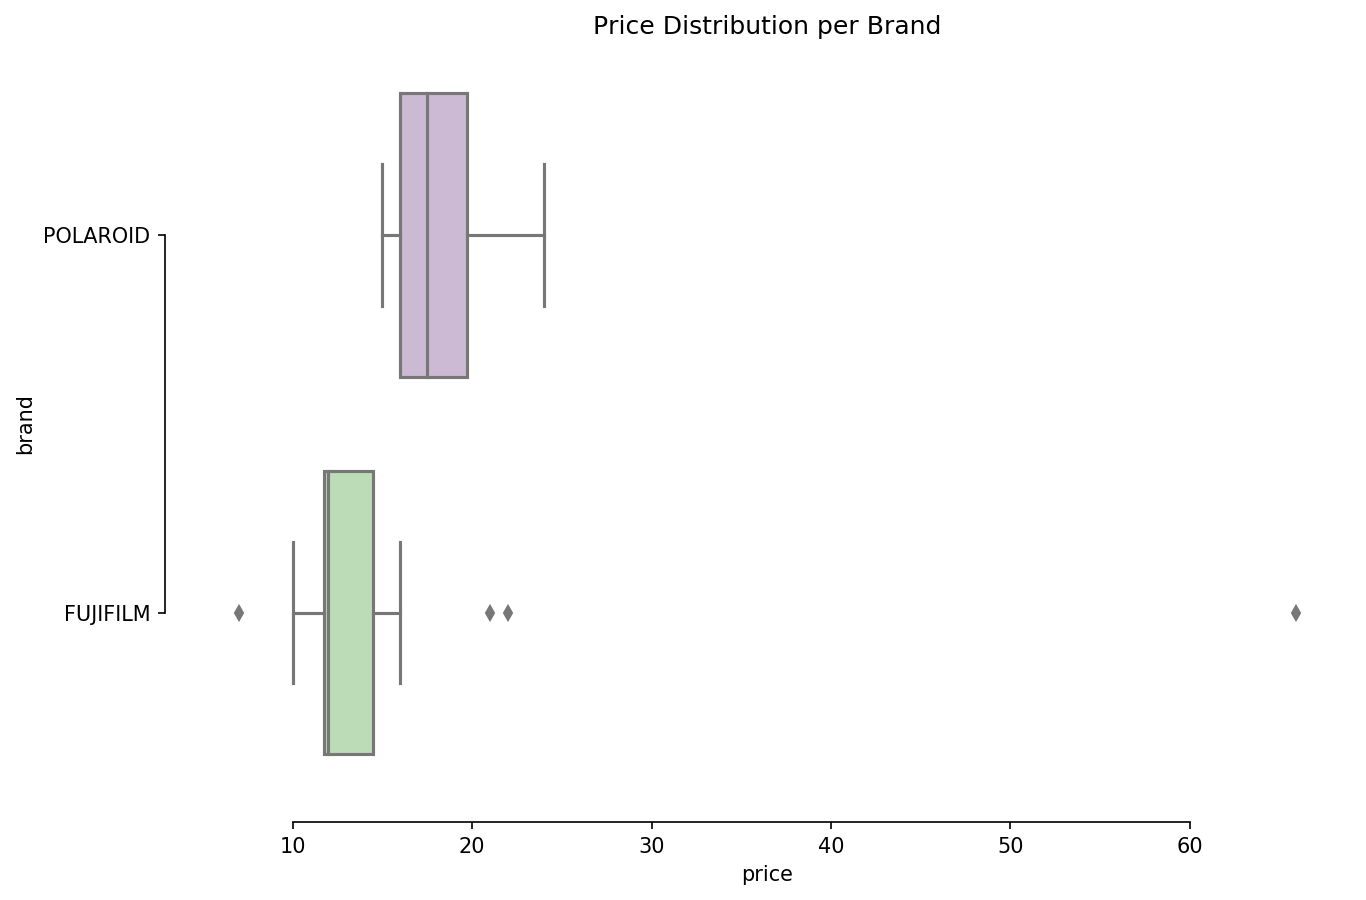

Visualization saved to ./plots/price_distribution_brand.png


In [132]:
query = total_products.dimension10 == 'Instantáneas y retro'

viz_data(dat, viz, query, 1500, 1000)